### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import tools
import model_egm_naive
import model_egm
from numba.types import double, int32
from numba.experimental import jitclass
from scipy.interpolate import interp1d
from model import run_model
from params import par_class
from scipy.stats import gaussian_kde

plt.style.use('science') # pip install git+https://github.com/garrettj403/SciencePlots.git

### Settings

In [2]:
fast = True
save = True
num_points = 16
dpi = 400

# Main figures

### Figure: No uncertainty

Fraction of early payments: 0.000


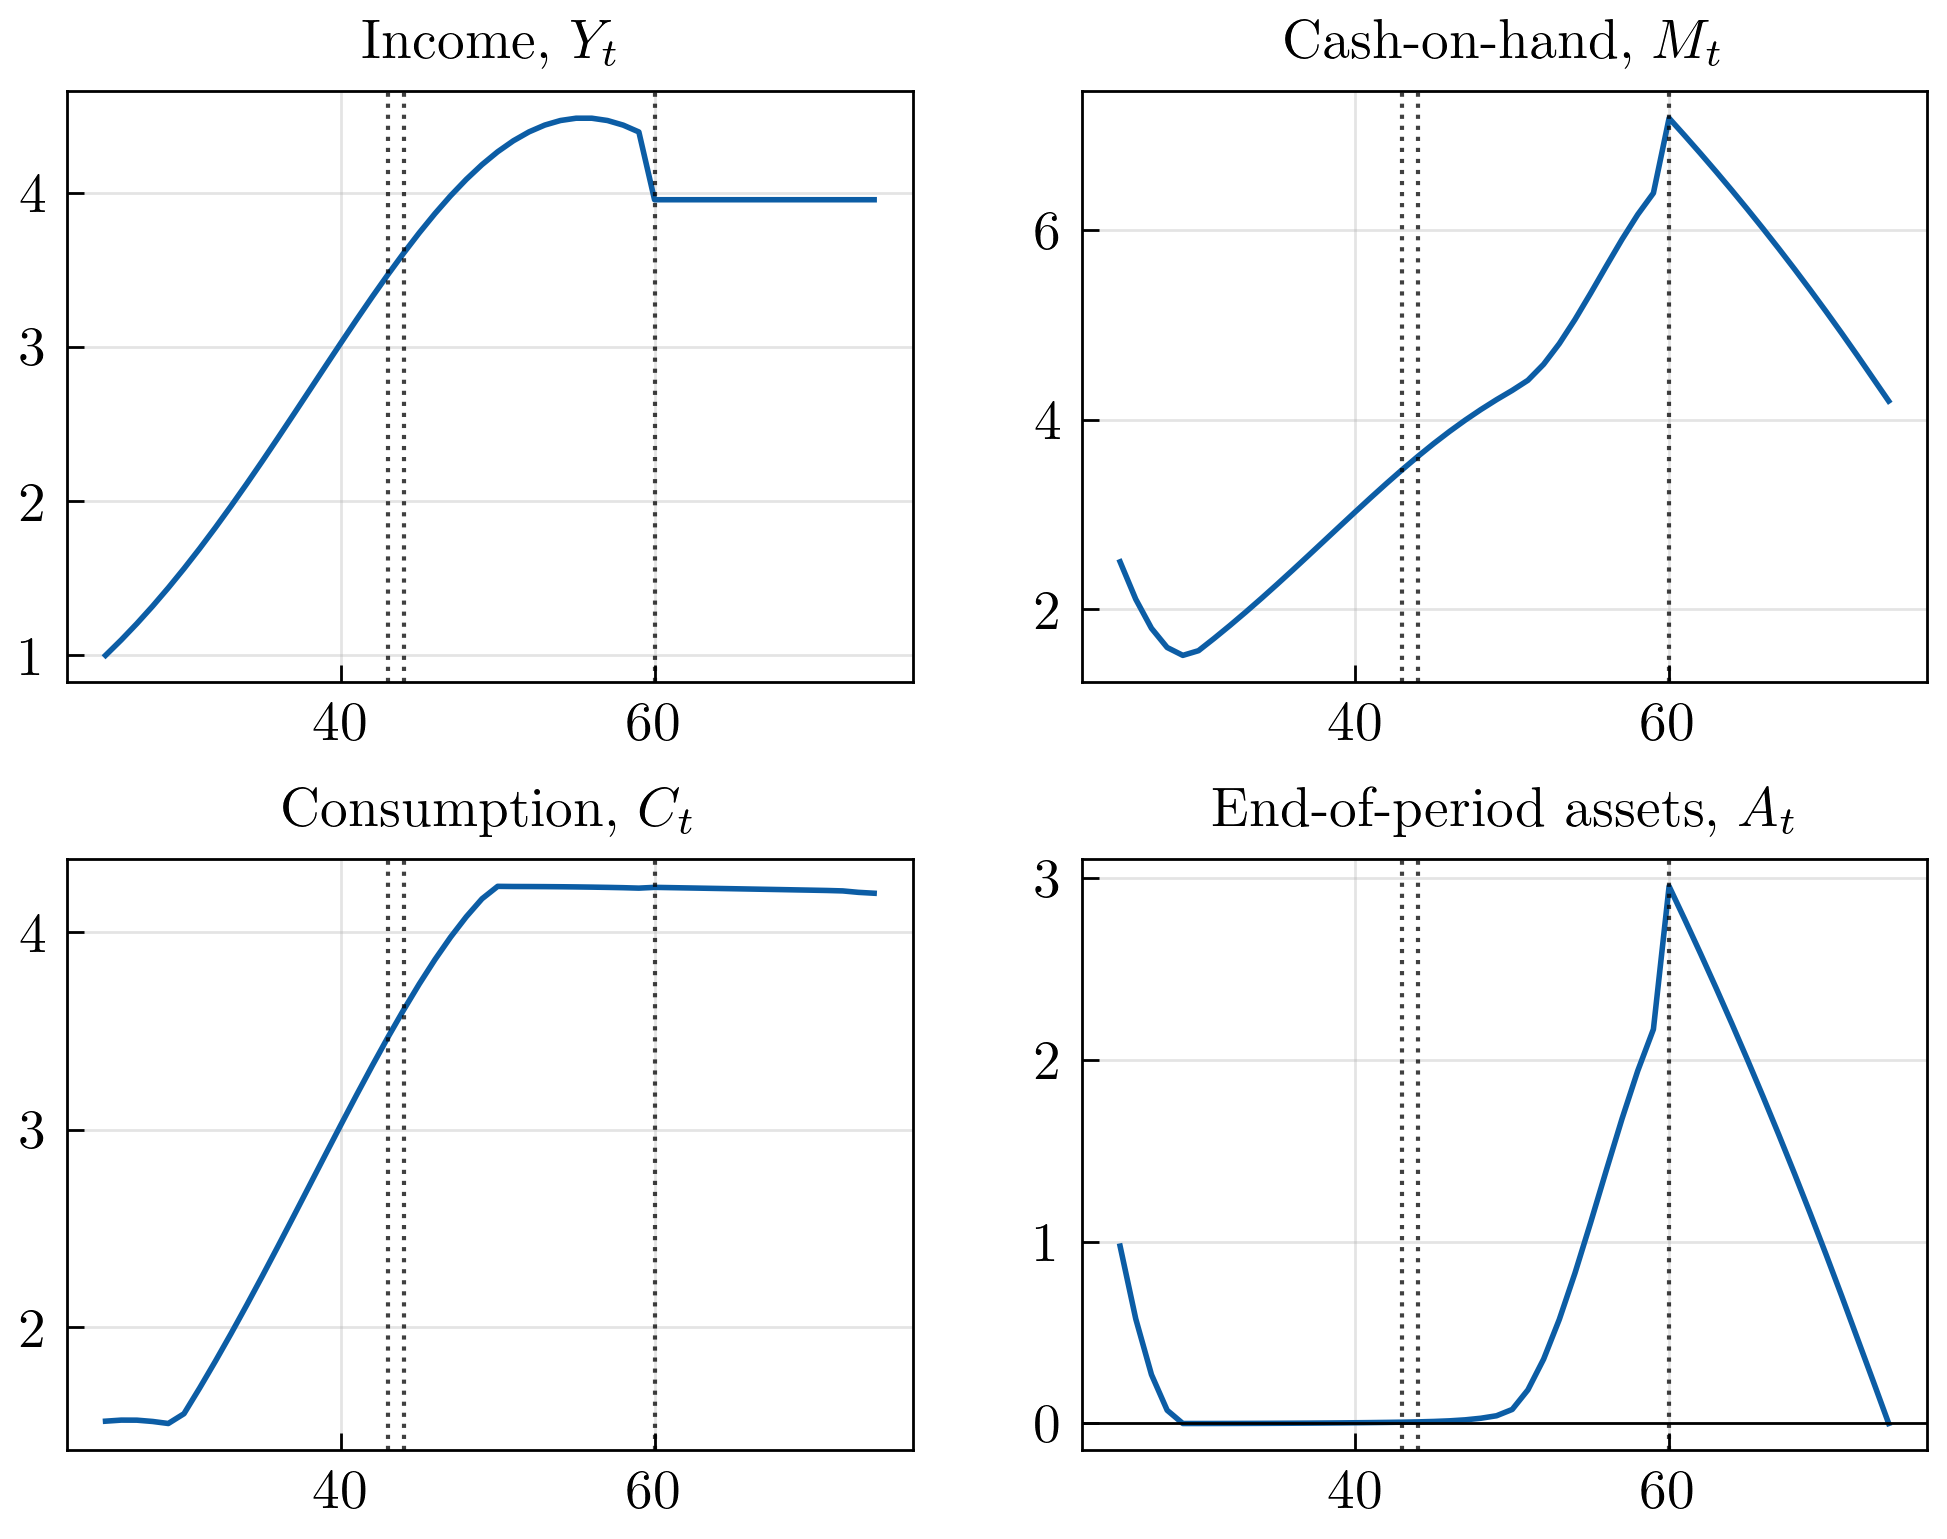

In [3]:
# Parameters
par = par_class()
par.pi = 0.0
par.sigma_d = 0.0
par.sigma_xi = 0.0
par.sigma_psi = 0.0
par.Nd = 1
par.Npsi = 1
par.Nxi = 1
if fast:
    par.Nm = 50
    par.Nh = 10

# Model
_, sim = run_model(par)

# Plot
fig,ax = plt.subplots(2,2,figsize=(6,4.5),dpi=dpi)
ax[0,0].plot(range(25,par.T+25), sim.Y.mean(axis=0))
ax[0,1].plot(range(25,par.T+25), sim.M.mean(axis=0))
ax[1,0].plot(range(25,par.T+25), sim.C.mean(axis=0))
ax[1,1].plot(range(25,par.T+25), sim.A.mean(axis=0))
ax[0,0].set_title('Income, $Y_t$', fontsize=10)
ax[0,1].set_title('Cash-on-hand, $M_t$', fontsize=10)
ax[1,0].set_title('Consumption, $C_t$', fontsize=10)
ax[1,1].set_title('End-of-period assets, $A_t$', fontsize=10)
for i in [0,1]:
    for j in [0,1]:
        ax[i,j].axvline(x=par.TH-1+25, color='black', alpha=3/4, ls=':', lw=3/4)
        ax[i,j].axvline(x=par.TH+25, color='black', alpha=3/4, ls=':', lw=3/4)
        ax[i,j].axvline(x=par.TR+25, color='black', alpha=3/4, ls=':', lw=3/4)
        ax[i,j].grid(alpha=1/3) # Make grid
        ax[i,j].minorticks_off() # Remove minor ticks
        ax[i,j].tick_params(top=False, right=False) # Remove major ticks on top and right 
        if (i,j) == (1,1): ax[i,j].axhline(0,color='black',alpha=1,lw=0.5) # Add zero line
fig.subplots_adjust(hspace=0.3)
print(f'Fraction of early payments: {sim.z.mean():.3f}')
if save: plt.savefig(r'figs\fig_no_uncertainty.png')

### Figure: With uncertainty

Fraction of early payments: 0.511


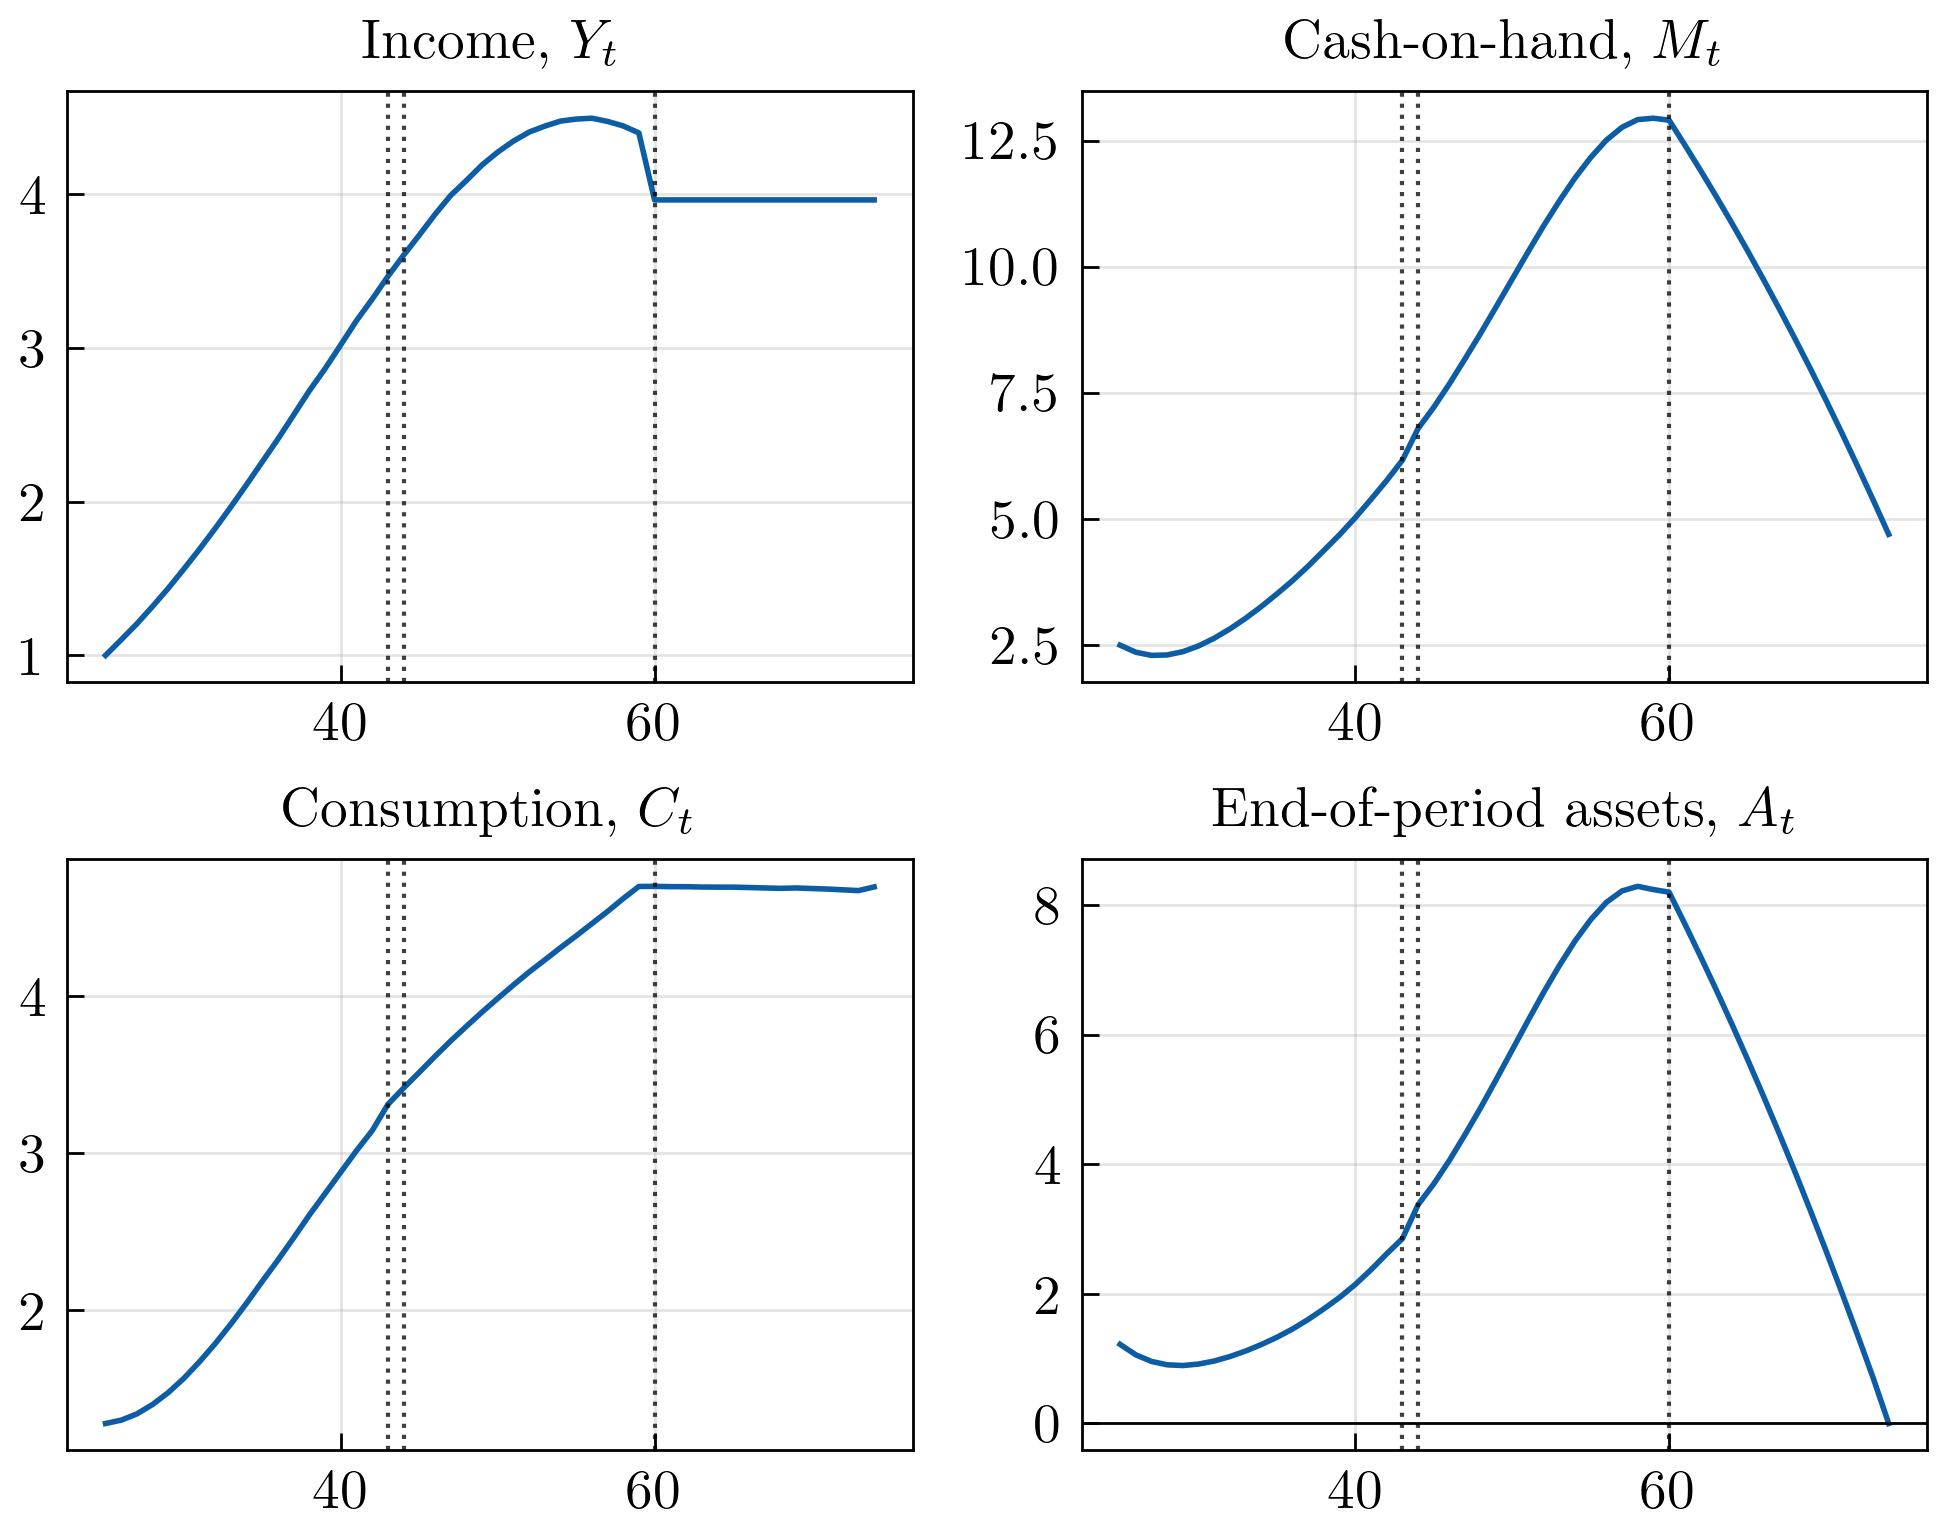

In [4]:
# Parameters
par = par_class()
if fast:
    par.Nm = 50
    par.Nh = 10

# Model
_, sim = run_model(par)

# Plot
fig,ax = plt.subplots(2,2,figsize=(6,4.5),dpi=dpi)
ax[0,0].plot(range(25,par.T+25), sim.Y.mean(axis=0))
ax[0,1].plot(range(25,par.T+25), sim.M.mean(axis=0))
ax[1,0].plot(range(25,par.T+25), sim.C.mean(axis=0))
ax[1,1].plot(range(25,par.T+25), sim.A.mean(axis=0))
ax[0,0].set_title('Income, $Y_t$', fontsize=10)
ax[0,1].set_title('Cash-on-hand, $M_t$', fontsize=10)
ax[1,0].set_title('Consumption, $C_t$', fontsize=10)
ax[1,1].set_title('End-of-period assets, $A_t$', fontsize=10)
for i in [0,1]:
    for j in [0,1]:
        ax[i,j].axvline(x=par.TH-1+25, color='black', alpha=3/4, ls=':', lw=3/4)
        ax[i,j].axvline(x=par.TH+25, color='black', alpha=3/4, ls=':', lw=3/4)
        ax[i,j].axvline(x=par.TR+25, color='black', alpha=3/4, ls=':', lw=3/4)
        ax[i,j].grid(alpha=1/3) # Make grid
        ax[i,j].minorticks_off() # Remove minor ticks
        ax[i,j].tick_params(top=False, right=False) # Remove major ticks on top and right 
        if (i,j) == (1,1): ax[i,j].axhline(0,color='black',alpha=1,lw=0.5) # Add zero line
fig.subplots_adjust(hspace=0.3)
print(f'Fraction of early payments: {sim.z.mean():.3f}')
if save: plt.savefig(r'figs\fig_with_uncertainty.png')

### Figure: Age profile

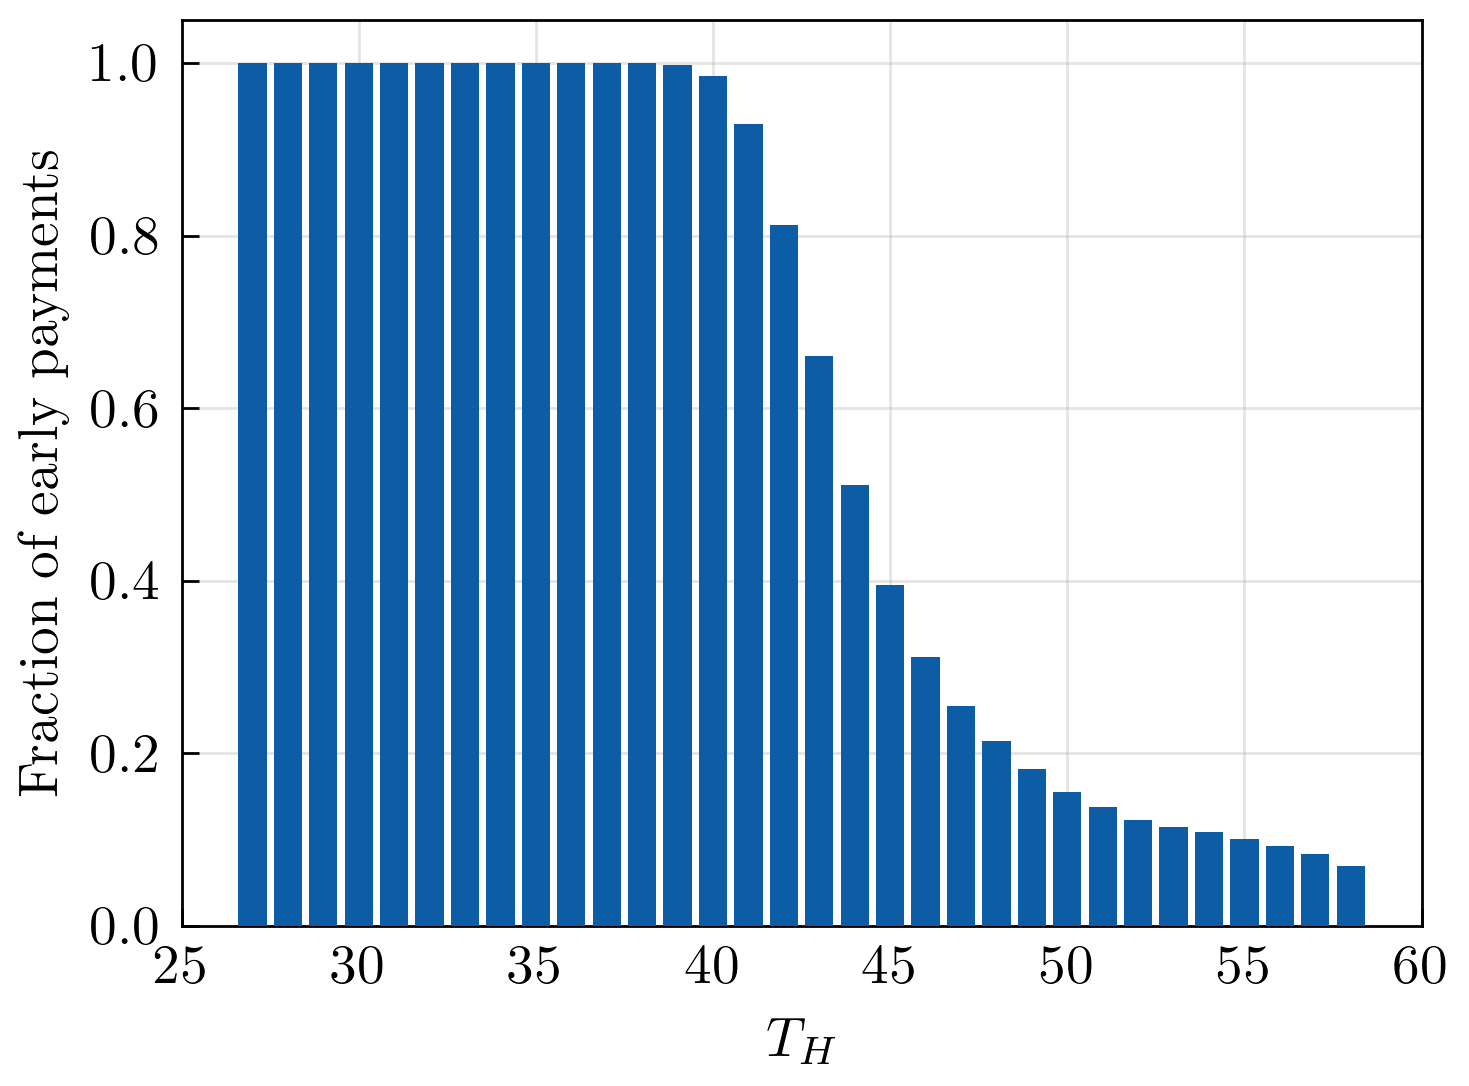

In [5]:
# Parameters
par = par_class()
if fast:
    par.Nm = 50
    par.Nh = 10
    
# Run models
zs = []
THs = np.linspace(2,33,32,dtype=int)
for TH in THs:
    par.TH = TH
    _, sim = run_model(par)
    z_mean = sim.z.mean()
    zs.append(z_mean)
    
# Graph
plt.figure(figsize=(4,3),dpi=dpi)
plt.bar(THs + 25,zs,zorder=3)
plt.grid(alpha=1/3,zorder=0)
plt.minorticks_off()
ax = plt.gca()
ax.tick_params(top=False, right=False)
plt.xlim([25,60])
plt.xlabel('$T_H$')
plt.ylabel('Fraction of early payments')
if save: plt.savefig(r'figs\fig_age_profile.png')

### Calculation: MPC

In [6]:
# Parameters
par = par_class()
if fast:
    par.Nm = 50
    par.Nh = 10
    
# Calculate consumption and holiday pay for people consuming early
_, sim = run_model(par)
N_early = sum(sim.z)
sim_C_early = np.nan + np.zeros((N_early,par.T))
sim_H_early  = np.nan + np.zeros((N_early,par.T))
i_early = 0
i_earlies = []
for i,z_i in enumerate(sim.z):
    if z_i == 1:
        i_earlies.append(i)
        sim_C_early[i_early,:] = sim.C[i,:]
        sim_H_early[i_early,:] = sim.H[i,:]
        i_early = i_early + 1
sim_C_total_w = sim_C_early[:,par.TH-1].sum(axis=0) + sim_C_early[:,par.TH].sum(axis=0)
H_total = sim_H_early[:,par.TH-1].sum(axis=0)

# Colculate consumption and holiday pay for people who would have consumed early
par.z_mode = 0
_, sim = run_model(par)
sim_C_total_wo = 0.0
for i in i_earlies:
    sim_C_total_wo += sim.C[i,par.TH-1] + sim.C[i,par.TH]
mpc_selection = (sim_C_total_w - sim_C_total_wo)/H_total

# Colculate 
sim_C_total_both_wo = sim.C[:,par.TH-1].sum(axis=0) + sim.C[:,par.TH].sum(axis=0)

# Colculate consumption forcing early payments
par.z_mode = 1
_, sim = run_model(par)
sim_C_total_both_w = sim.C[:,par.TH-1].sum(axis=0) + sim.C[:,par.TH].sum(axis=0)
H_total_both = sim.H[:,par.TH-1].sum(axis=0)
mpc_forced = (sim_C_total_both_w - sim_C_total_both_wo)/H_total_both

print(f'MPC with self-selection:  {mpc_selection:.3f}')
print(f'MPC with forced payments: {mpc_forced:.3f}')

MPC with self-selection:  0.313
MPC with forced payments: 0.231


### Figure: Exogenous holiday pay timing

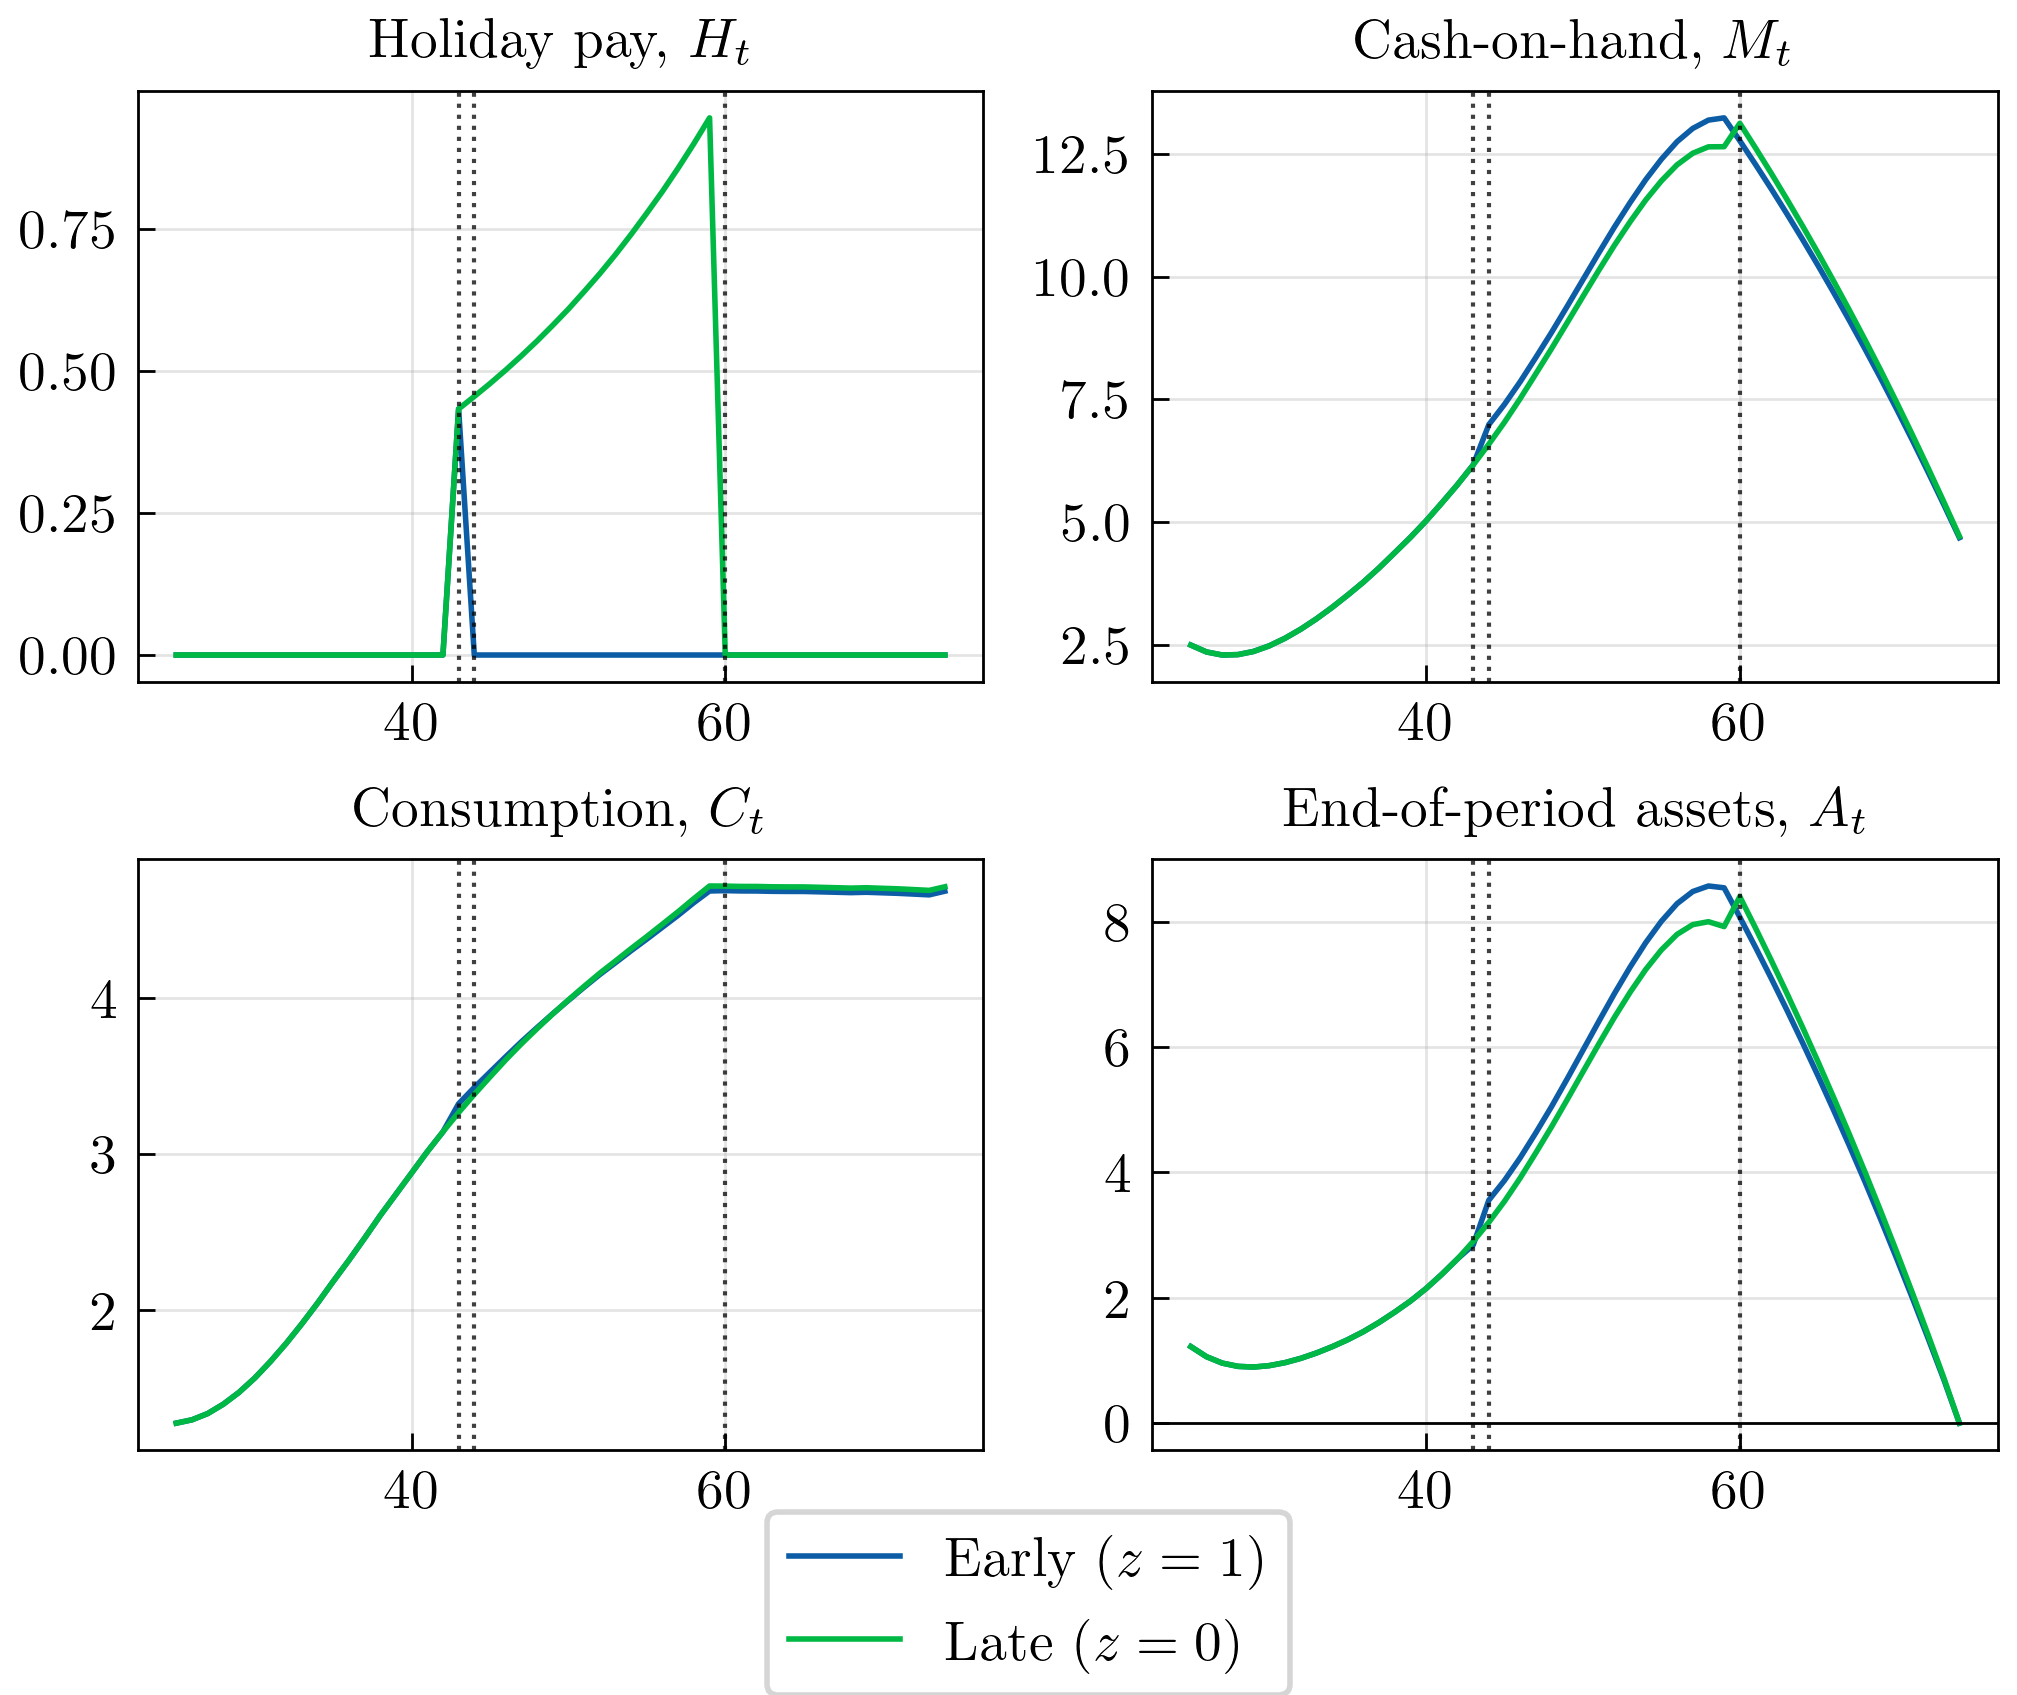

In [7]:
# Parameters
par = par_class()
par.z_mode = 1
if fast:
    par.Nm = 50
    par.Nh = 10

# Model
_, sim_early = run_model(par)
par.z_mode = 0
_, sim_late = run_model(par)

# Plot
fig,ax = plt.subplots(2,2,figsize=(6,4.5),dpi=dpi)
ax[0,0].plot(range(25,par.T+25), sim_early.H.mean(axis=0), label='Early ($z=1$)')
ax[0,0].plot(range(25,par.T+25), sim_late.H.mean(axis=0), label='Late ($z=0$)')
ax[0,1].plot(range(25,par.T+25), sim_early.M.mean(axis=0), label='Early ($z=1$)')
ax[0,1].plot(range(25,par.T+25), sim_late.M.mean(axis=0), label='Late ($z=0$)')
ax[1,0].plot(range(25,par.T+25), sim_early.C.mean(axis=0), label='Early ($z=1$)')
ax[1,0].plot(range(25,par.T+25), sim_late.C.mean(axis=0), label='Late ($z=0$)')
ax[1,1].plot(range(25,par.T+25), sim_early.A.mean(axis=0), label='Early ($z=1$)')
ax[1,1].plot(range(25,par.T+25), sim_late.A.mean(axis=0), label='Late ($z=0$)')
ax[0,0].set_title('Holiday pay, $H_t$', fontsize=10)
ax[0,1].set_title('Cash-on-hand, $M_t$', fontsize=10)
ax[1,0].set_title('Consumption, $C_t$', fontsize=10)
ax[1,1].set_title('End-of-period assets, $A_t$', fontsize=10)
for i in [0,1]:
    for j in [0,1]:
        ax[i,j].axvline(x=par.TH-1+25, color='black', alpha=3/4, ls=':', lw=3/4)
        ax[i,j].axvline(x=par.TH+25, color='black', alpha=3/4, ls=':', lw=3/4)
        ax[i,j].axvline(x=par.TR+25, color='black', alpha=3/4, ls=':', lw=3/4)
        ax[i,j].grid(alpha=1/3) # Make grid
        ax[i,j].minorticks_off() # Remove minor ticks
        ax[i,j].tick_params(top=False, right=False) # Remove major ticks on top and right 
        if (i,j) == (1,1): ax[i,j].axhline(0,color='black',alpha=1,lw=0.5) # Add zero line
fig.subplots_adjust(hspace=0.3)
handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.38,0.00), frameon=True)
if save: plt.savefig(r'figs\fig_exo_ha.png')

### Figure: Endogenous holiday pay timining

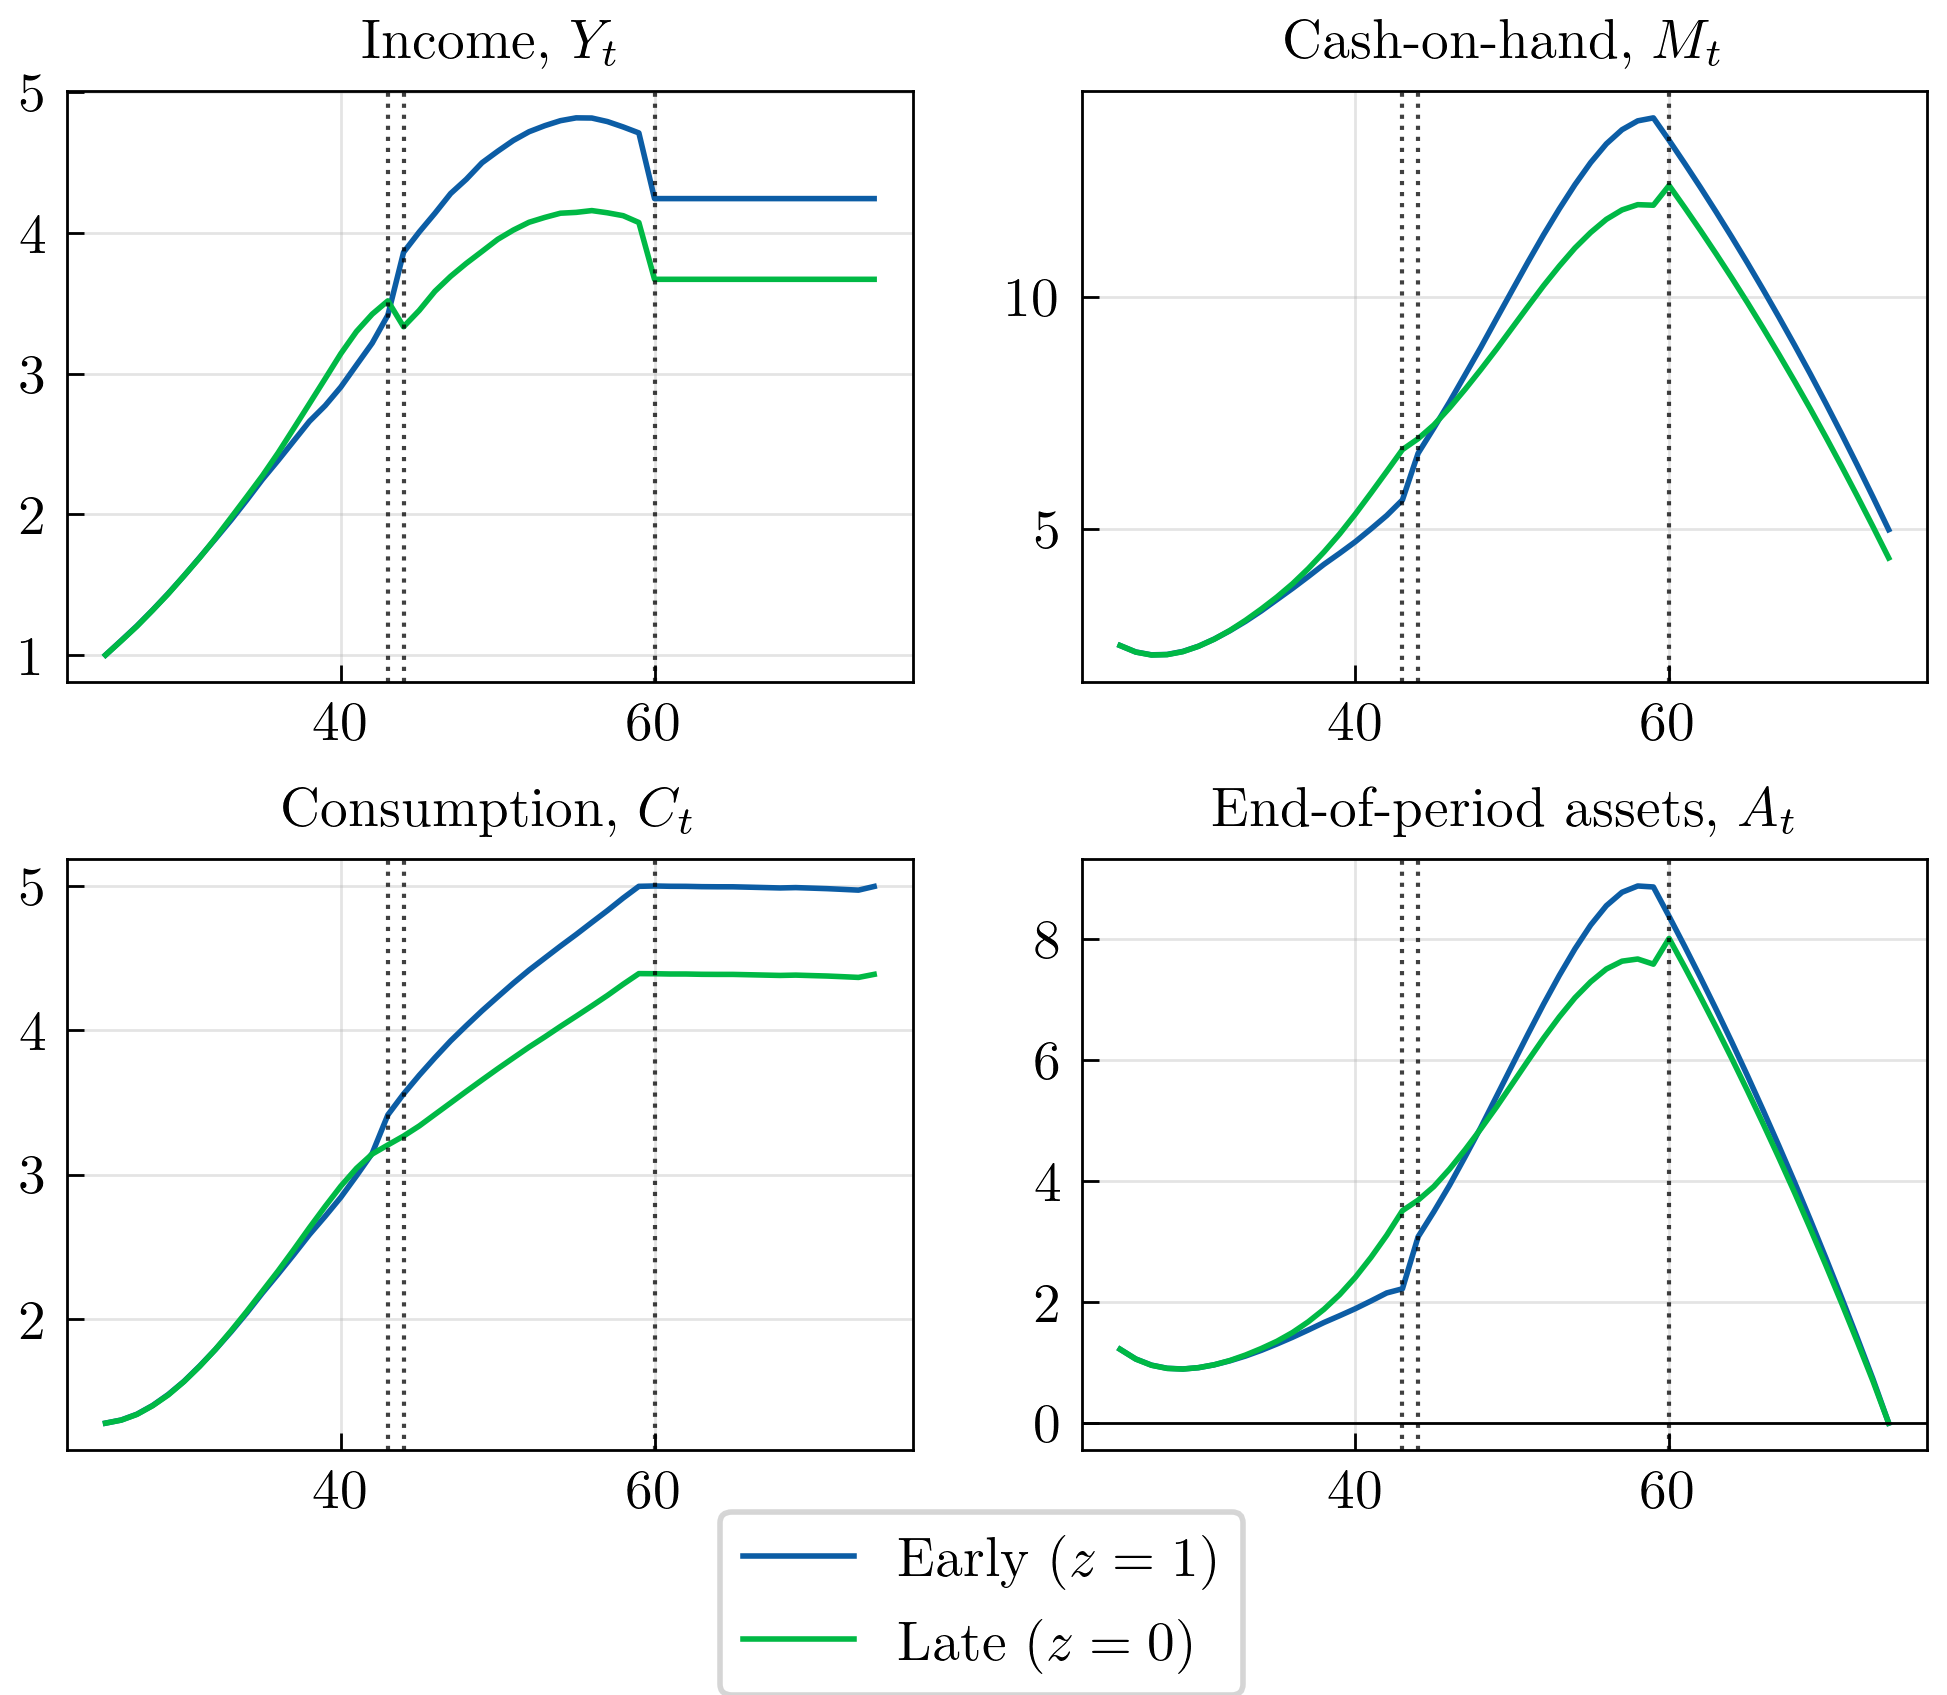

In [8]:
# Parameters
par = par_class()
if fast:
    par.Nm = 50
    par.Nh = 10

# Model
_, sim = run_model(par)

# Seperate time series for early and late payments
N_early = sum(sim.z)
N_late  = par.simN - N_early
sim_Y_early = np.nan + np.zeros((N_early,par.T))
sim_Y_late  = np.nan + np.zeros((N_late,par.T))
sim_M_early = np.nan + np.zeros((N_early,par.T))
sim_M_late  = np.nan + np.zeros((N_late,par.T))
sim_C_early = np.nan + np.zeros((N_early,par.T))
sim_C_late  = np.nan + np.zeros((N_late,par.T))
sim_A_early = np.nan + np.zeros((N_early,par.T))
sim_A_late  = np.nan + np.zeros((N_late,par.T))
i_early = 0
i_late  = 0
for i,z_i in enumerate(sim.z):
    if z_i == 1:
        sim_Y_early[i_early,:] = sim.Y[i,:]
        sim_M_early[i_early,:] = sim.M[i,:]
        sim_C_early[i_early,:] = sim.C[i,:]
        sim_A_early[i_early,:] = sim.A[i,:]
        i_early = i_early + 1
    else:
        sim_Y_late[i_late,:] = sim.Y[i,:]
        sim_M_late[i_late,:] = sim.M[i,:]
        sim_C_late[i_late,:] = sim.C[i,:]
        sim_A_late[i_late,:] = sim.A[i,:]
        i_late = i_late + 1

# Plot
fig,ax = plt.subplots(2,2,figsize=(6,4.5),dpi=dpi)
ax[0,0].plot(range(25,par.T+25), sim_Y_early.mean(axis=0), label='Early ($z=1$)')
ax[0,0].plot(range(25,par.T+25), sim_Y_late.mean(axis=0), label='Late ($z=0$)')
ax[0,1].plot(range(25,par.T+25), sim_M_early.mean(axis=0), label='Early ($z=1$)')
ax[0,1].plot(range(25,par.T+25), sim_M_late.mean(axis=0), label='Late ($z=0$)')
ax[1,0].plot(range(25,par.T+25), sim_C_early.mean(axis=0), label='Early ($z=1$)')
ax[1,0].plot(range(25,par.T+25), sim_C_late.mean(axis=0), label='Late ($z=0$)')
ax[1,1].plot(range(25,par.T+25), sim_A_early.mean(axis=0), label='Early ($z=1$)')
ax[1,1].plot(range(25,par.T+25), sim_A_late.mean(axis=0), label='Late ($z=0$)')
ax[0,0].set_title('Income, $Y_t$', fontsize=10)
ax[0,1].set_title('Cash-on-hand, $M_t$', fontsize=10)
ax[1,0].set_title('Consumption, $C_t$', fontsize=10)
ax[1,1].set_title('End-of-period assets, $A_t$', fontsize=10)
for i in [0,1]:
    for j in [0,1]:
        ax[i,j].axvline(x=par.TH-1+25, color='black', alpha=3/4, ls=':', lw=3/4)
        ax[i,j].axvline(x=par.TH+25, color='black', alpha=3/4, ls=':', lw=3/4)
        ax[i,j].axvline(x=par.TR+25, color='black', alpha=3/4, ls=':', lw=3/4)
        ax[i,j].grid(alpha=1/3) # Make grid
        ax[i,j].minorticks_off() # Remove minor ticks
        ax[i,j].tick_params(top=False, right=False) # Remove major ticks on top and right 
        if (i,j) == (1,1): ax[i,j].axhline(0,color='black',alpha=1,lw=0.5) # Add zero line
fig.subplots_adjust(hspace=0.3)
handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.37,0.00), frameon=True)
if save: plt.savefig(r'figs\fig_endo_ha.png')

### Figure: Asset histograms

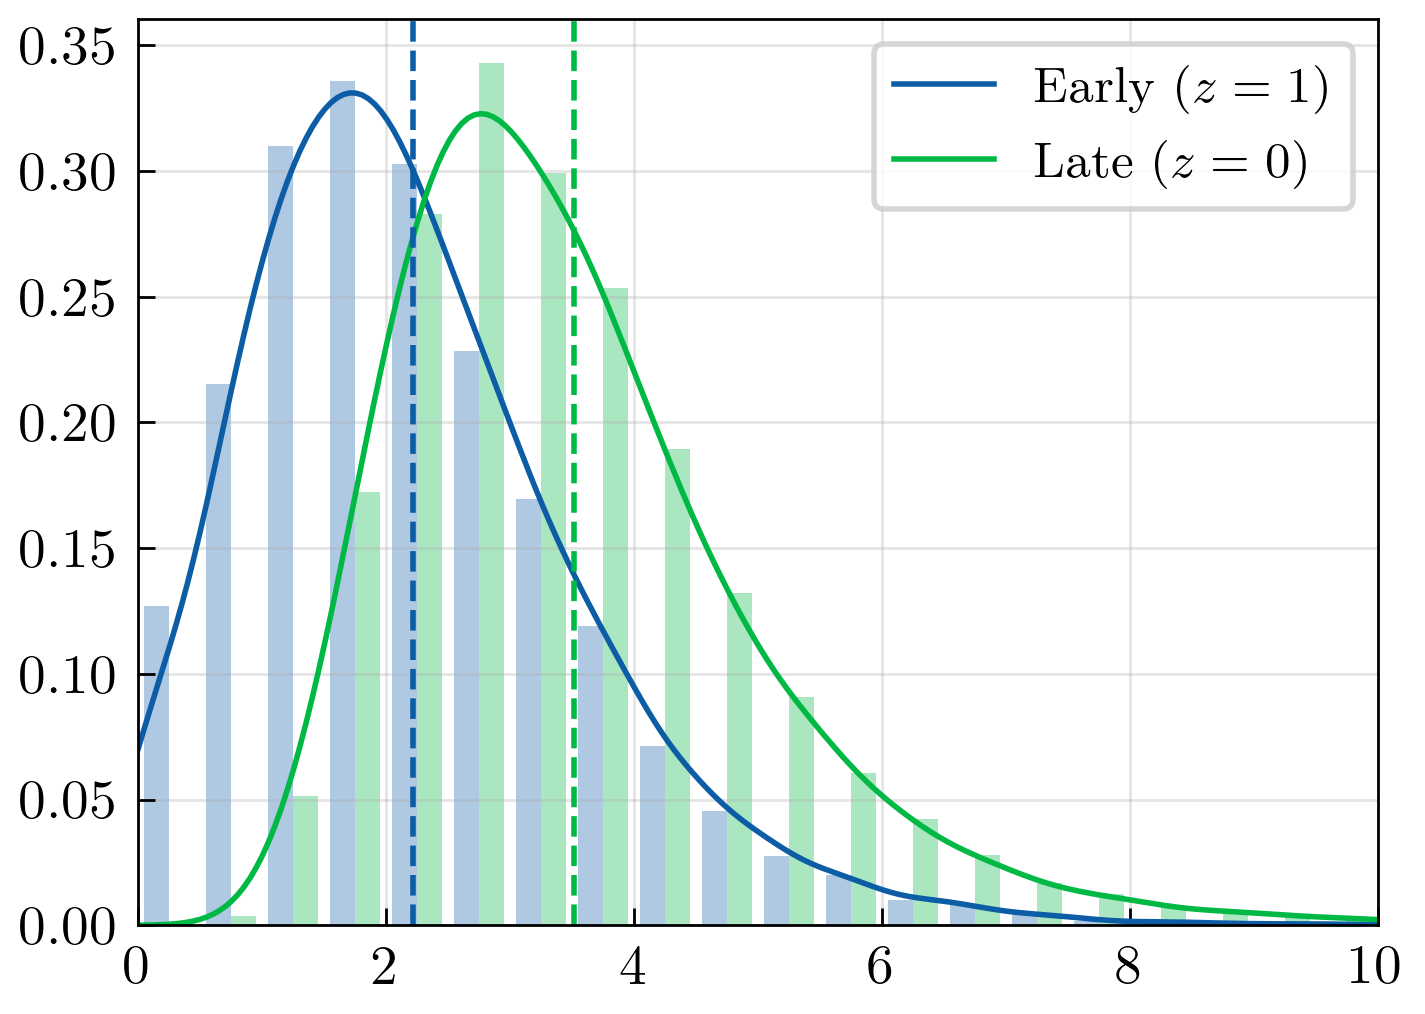

In [9]:
# Compute kernel densities
xs = np.linspace(0,10,200)
density_early = gaussian_kde(sim_A_early[:,par.TH-1], bw_method=0.2)
density_late = gaussian_kde(sim_A_late[:,par.TH-1], bw_method=0.2)

# Do figure
plt.figure(figsize=(4,3),dpi=dpi)
plt.plot(xs,density_early(xs), color='#0C5DA5', label='Early ($z=1$)')
plt.plot(xs,density_late(xs), color='#00B945', label='Late ($z=0$)')
plt.hist([sim_A_early[:,par.TH-1],sim_A_late[:,par.TH-1]], alpha=1/3, density = True, bins = np.linspace(0,10,21))
plt.axvline(sim_A_early[:,par.TH-1].mean(), color='#0C5DA5', ls='--')
plt.axvline(sim_A_late[:,par.TH-1].mean(), color='#00B945', ls='--')
plt.xlim([0,10])
plt.grid(alpha=1/3)
plt.minorticks_off() 
ax = plt.gca()
ax.tick_params(top=False, right=False)
plt.legend(frameon=True, fontsize=9)
if save: plt.savefig(r'figs\fig_asset_hist.png')

### Figure: Comparison of VFI and EGM

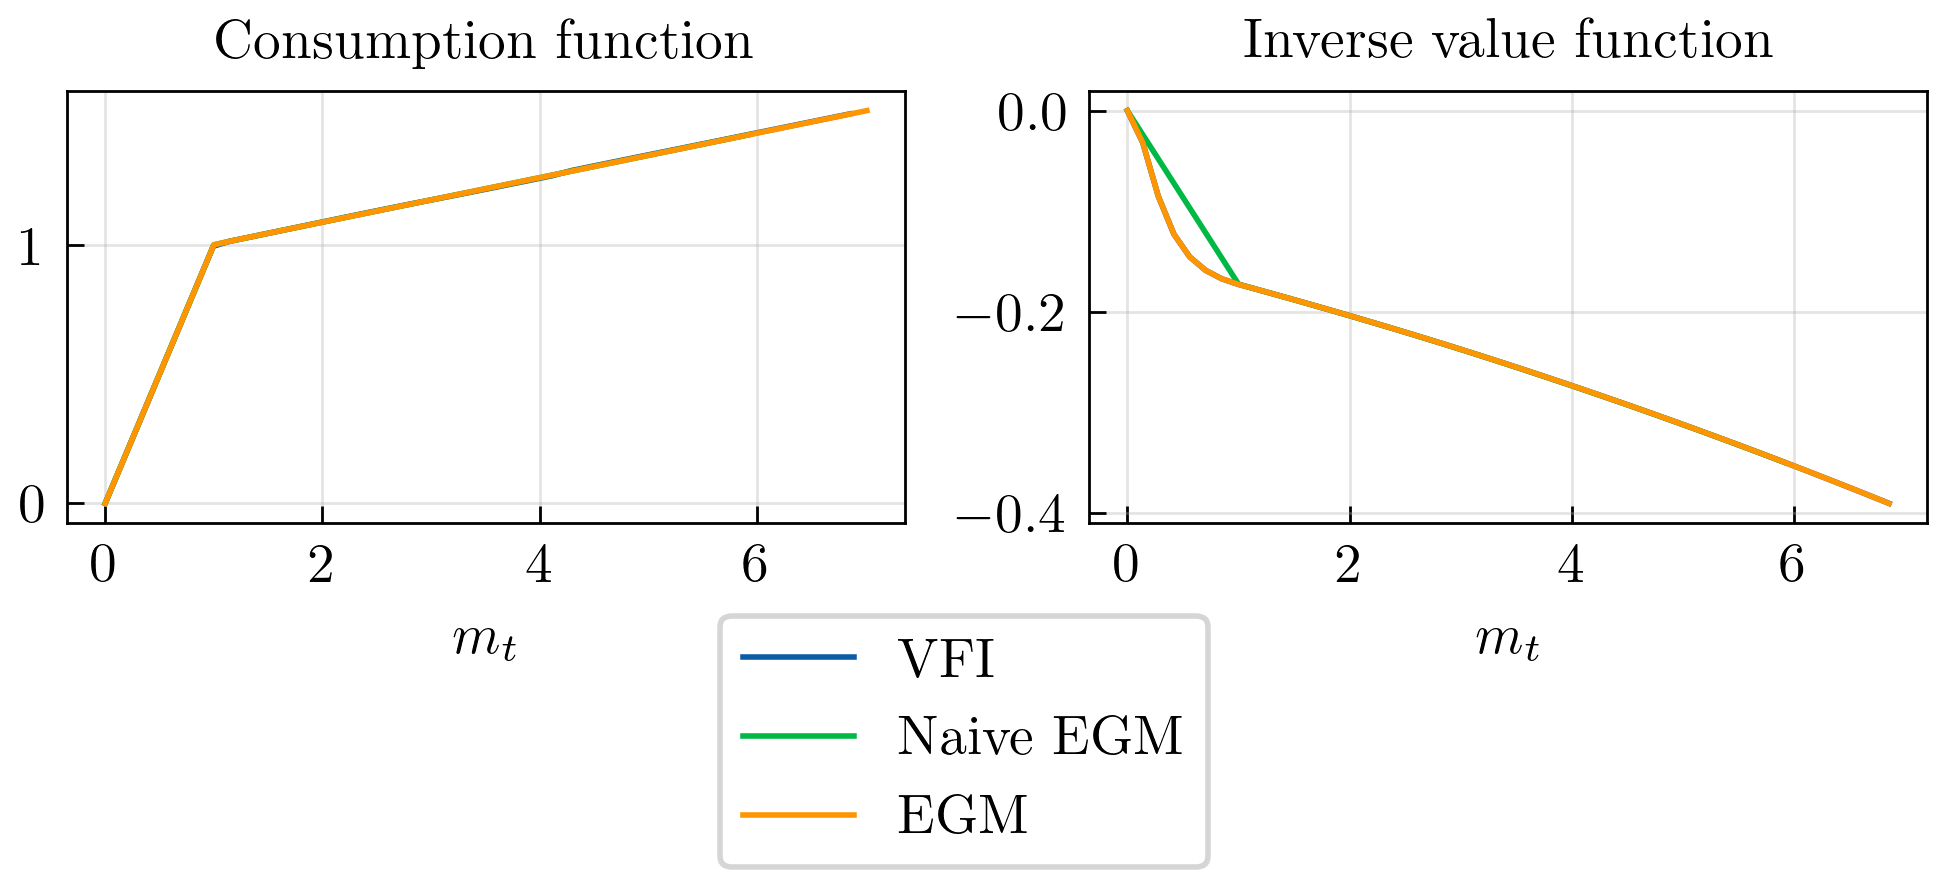

In [10]:
# Run models
par = par_class()
if fast:
    par.Nm = 50
    par.Na = 50
    par.Nh = 10
par.simN = 1
sol, sim = run_model(par)
sol_egm, sim_egm = model_egm.run_model(par)
sol_egm_naive, sim_egm_naive = model_egm_naive.run_model(par)

# Plot value functions
t = par.TR+1
z = 1
i_h = 5
grid_m = tools.nonlinspace(1e-6,par.m_max,par.Nm,par.m_phi)
fig,ax = plt.subplots(1,2,figsize=(6,2.25),dpi=dpi)
ax[0].plot(grid_m[:40], sol.c[t,:40,z,i_h], label='VFI')
ax[0].plot(sol_egm_naive.m[t,:30,z,i_h], sol_egm_naive.c[t,:30,z,i_h], label='Naive EGM')
ax[0].plot(sol_egm.m[t,:35,z,i_h], sol_egm.c[t,:35,z,i_h], label='EGM')
ax[1].plot(grid_m[:40], sol.inv_v[t,:40,z,i_h], label='VFI')
ax[1].plot(sol_egm_naive.m[t,:30,z,i_h], sol_egm_naive.inv_v[t,:30,z,i_h], label='Naive EGM')
ax[1].plot(grid_m[:40], sol_egm.inv_v[t,:40,z,i_h], label='EGM')
ax[0].set_title('Consumption function', fontsize=10)
ax[1].set_title('Inverse value function', fontsize=10)
ax[0].grid(alpha=1/3)
ax[1].grid(alpha=1/3)
ax[0].minorticks_off()
ax[1].minorticks_off()
ax[0].tick_params(top=False, right=False)
ax[1].tick_params(top=False, right=False)
ax[0].set_xlabel(r'$m_t$')
ax[1].set_xlabel(r'$m_t$')
fig.subplots_adjust(wspace=0.22)
fig.subplots_adjust(bottom=0.4)
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.37,0.02), frameon=True)
if save: plt.savefig(r'figs\fig_naive_egm.png')

### Figure: Grid Illustration

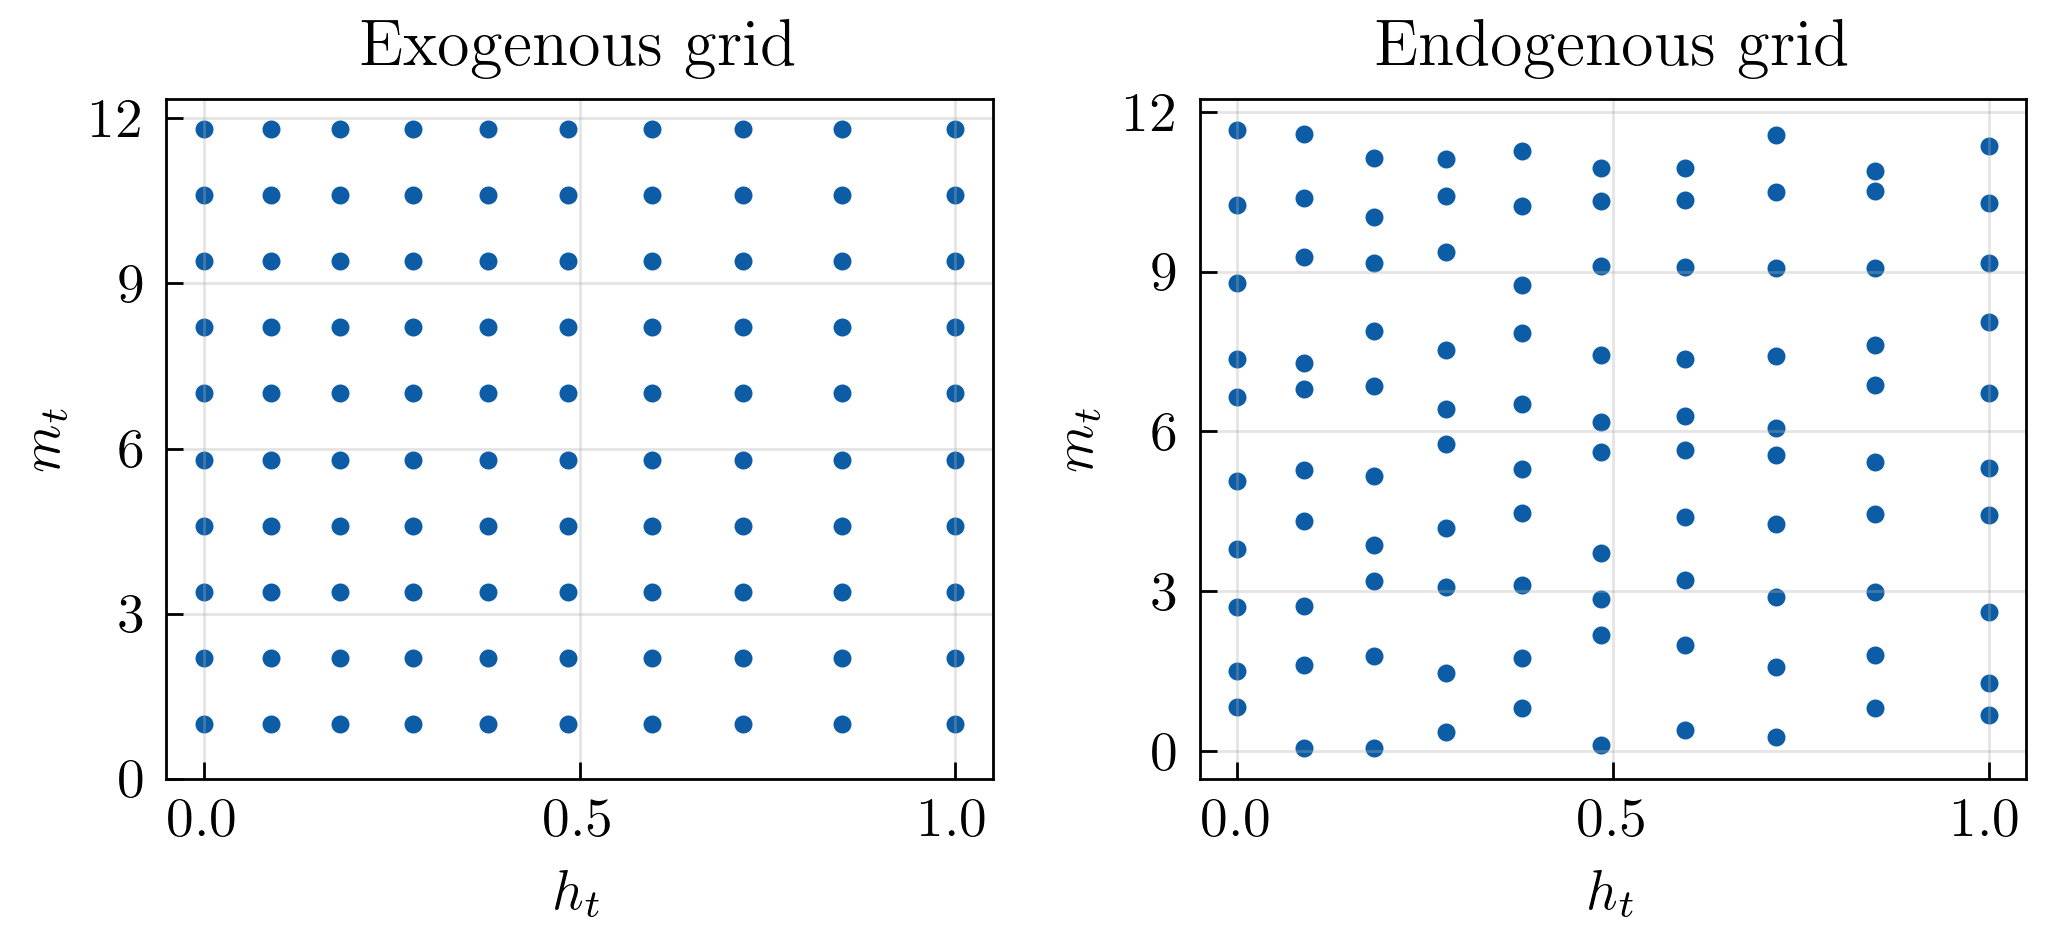

In [11]:
# Generate points
points_irregular = []
for h in tools.nonlinspace(0, 1, 10, 1.1):
    for i in range(10):
        m = np.random.uniform(1.2*i,1.2*i+1)
        point = [h, m]
        points_irregular.append(point)
x_irregular = [point[0] for point in points_irregular]
y_irregular = [point[1] for point in points_irregular]

# Generate points
points_regular = []
for h in tools.nonlinspace(0, 1, 10, 1.1):
    for i in range(10):
        m = 1.2*i+1
        point = [h, m]
        points_regular.append(point)
x_regular = [point[0] for point in points_regular]
y_regular = [point[1] for point in points_regular]

fig,ax = plt.subplots(1,2,figsize=(6,2.25),dpi=dpi)
ax[0].scatter(x_regular, y_regular, s=5)
ax[1].scatter(x_irregular, y_irregular, s=5)
ax[0].set_title('Exogenous grid')
ax[1].set_title('Endogenous grid')
ax[0].grid(alpha=1/3)
ax[1].grid(alpha=1/3)
ax[0].minorticks_off()
ax[1].minorticks_off()
ax[0].tick_params(top=False, right=False)
ax[1].tick_params(top=False, right=False)
ax[0].yaxis.set_ticks([0,3,6,9,12])
ax[1].yaxis.set_ticks([0,3,6,9,12])
ax[0].set_xlabel(r'$h_t$')
ax[1].set_xlabel(r'$h_t$')
ax[0].set_ylabel(r'$m_t$')
ax[1].set_ylabel(r'$m_t$')
fig.subplots_adjust(wspace=0.25)
if save: plt.savefig(r'figs\fig_grids.png')

# Robustness checks

### Varying $\beta$

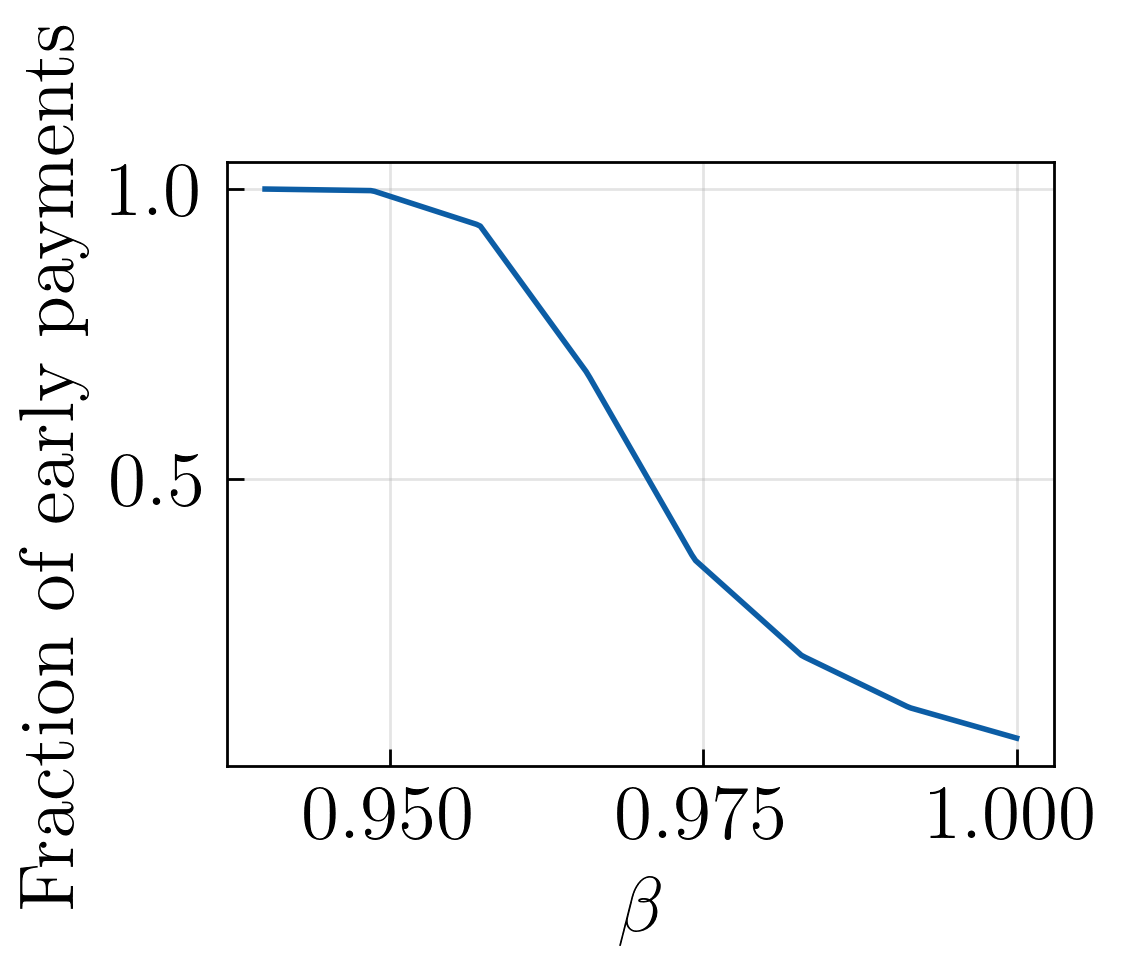

In [12]:
# Parameters
par = par_class()
if fast:
    par.Nm = 50
    par.Nh = 10
    num_points = 8

# Run models
beta_min = 0.94
beta_max = 1.00

zs = []
betas = np.linspace(beta_min, beta_max, num_points)
for beta in betas:
    par.beta = beta
    _, sim = run_model(par)
    zs.append(sim.z.mean())

# Interpolate
interpolator = interp1d(betas, zs, kind='linear')
betas_interp = np.linspace(beta_min, beta_max, num=200, endpoint=True)
zs_interp = interpolator(betas_interp)

# Graph
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8/3,2),dpi=dpi)
plt.plot(betas_interp,zs_interp)
plt.grid(alpha=1/3)
plt.minorticks_off()
ax = plt.gca()
ax.tick_params(top=False, right=False)
plt.xlabel(r'$\beta$')
plt.ylabel('Fraction of early payments')
if save: plt.savefig(r'figs\fig_var_beta.png')

### Varying $\rho$

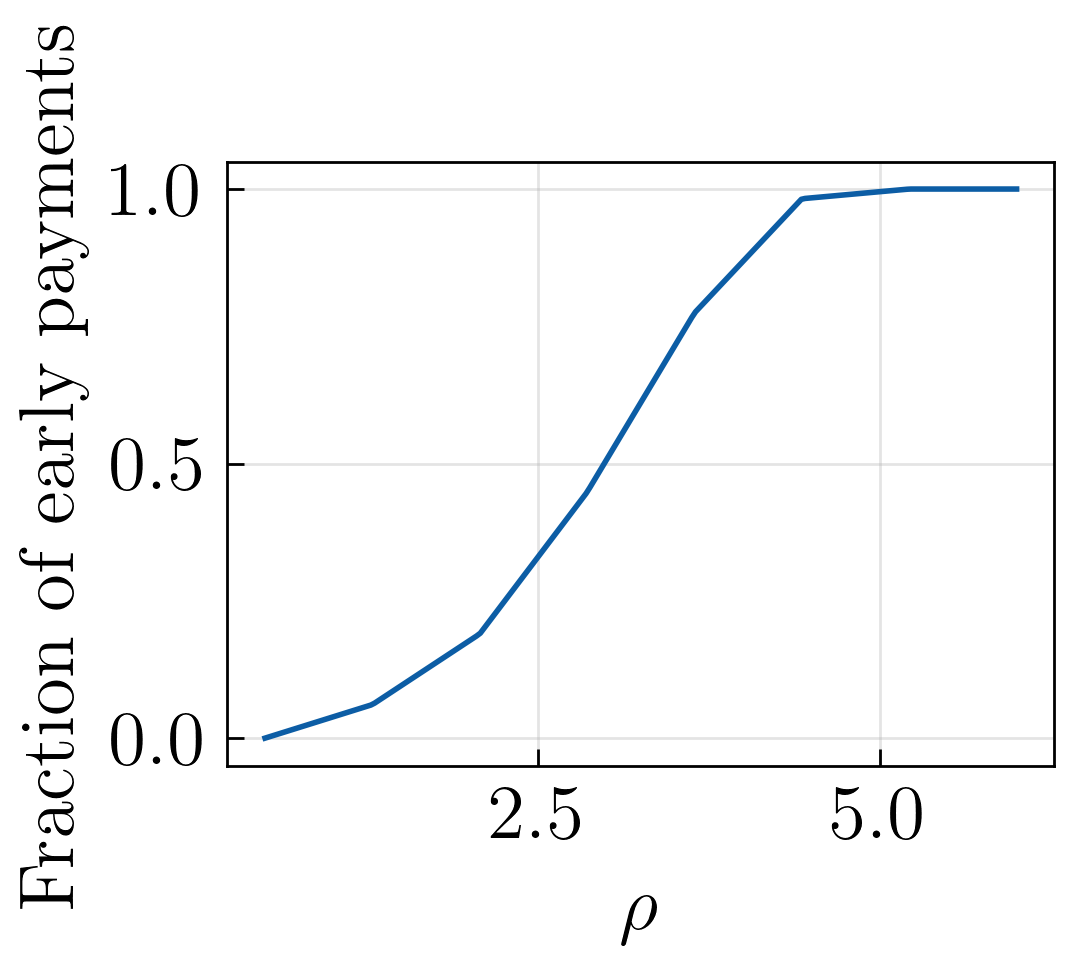

In [13]:
# Parameters
par = par_class()
if fast:
    par.Nm = 50
    par.Nh = 10
    num_points = 8

# Run models
rho_min = 0.5
rho_max = 6.0

zs = []
rhos = np.linspace(rho_min, rho_max, num_points)
for rho in rhos:
    par.rho = rho
    _, sim = run_model(par)
    zs.append(sim.z.mean())

# Interpolate
interpolator = interp1d(rhos, zs, kind='linear')
rhos_interp = np.linspace(rho_min, rho_max, num=200, endpoint=True)
zs_interp = interpolator(rhos_interp)

# Graph
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8/3,2),dpi=dpi)
plt.plot(rhos_interp,zs_interp)
plt.grid(alpha=1/3)
plt.minorticks_off()
ax = plt.gca()
ax.tick_params(top=False, right=False)
plt.xlabel(r'$\rho$')
plt.ylabel('Fraction of early payments')
if save: plt.savefig(r'figs\fig_var_rho.png')

### Varying $R$

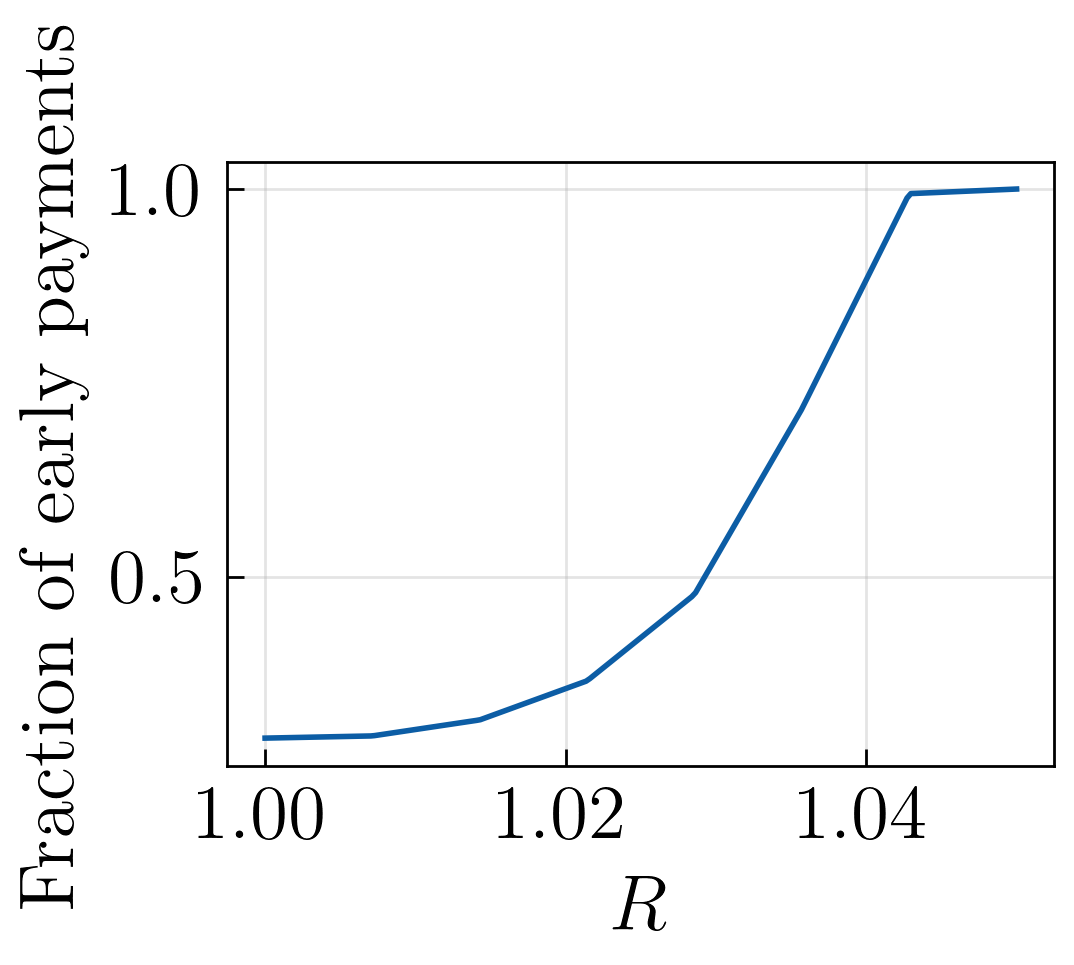

In [14]:
# Parameters
par = par_class()
if fast:
    par.Nm = 50
    par.Nh = 10
    num_points = 8

# Run models
R_min = 1.00
R_max = 1.05

zs = []
Rs = np.linspace(R_min, R_max, num_points)
for R in Rs:
    par.R = R
    _, sim = run_model(par)
    zs.append(sim.z.mean())

# Interpolate
interpolator = interp1d(Rs, zs, kind='linear')
Rs_interp = np.linspace(R_min, R_max, num=200, endpoint=True)
zs_interp = interpolator(Rs_interp)

# Graph
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8/3,2),dpi=dpi)
plt.plot(Rs_interp,zs_interp)
plt.grid(alpha=1/3)
plt.minorticks_off()
ax = plt.gca()
ax.tick_params(top=False, right=False)
plt.xlabel(r'$R$')
plt.ylabel('Fraction of early payments')
if save: plt.savefig(r'figs\fig_var_R.png')

### Varying $\delta$

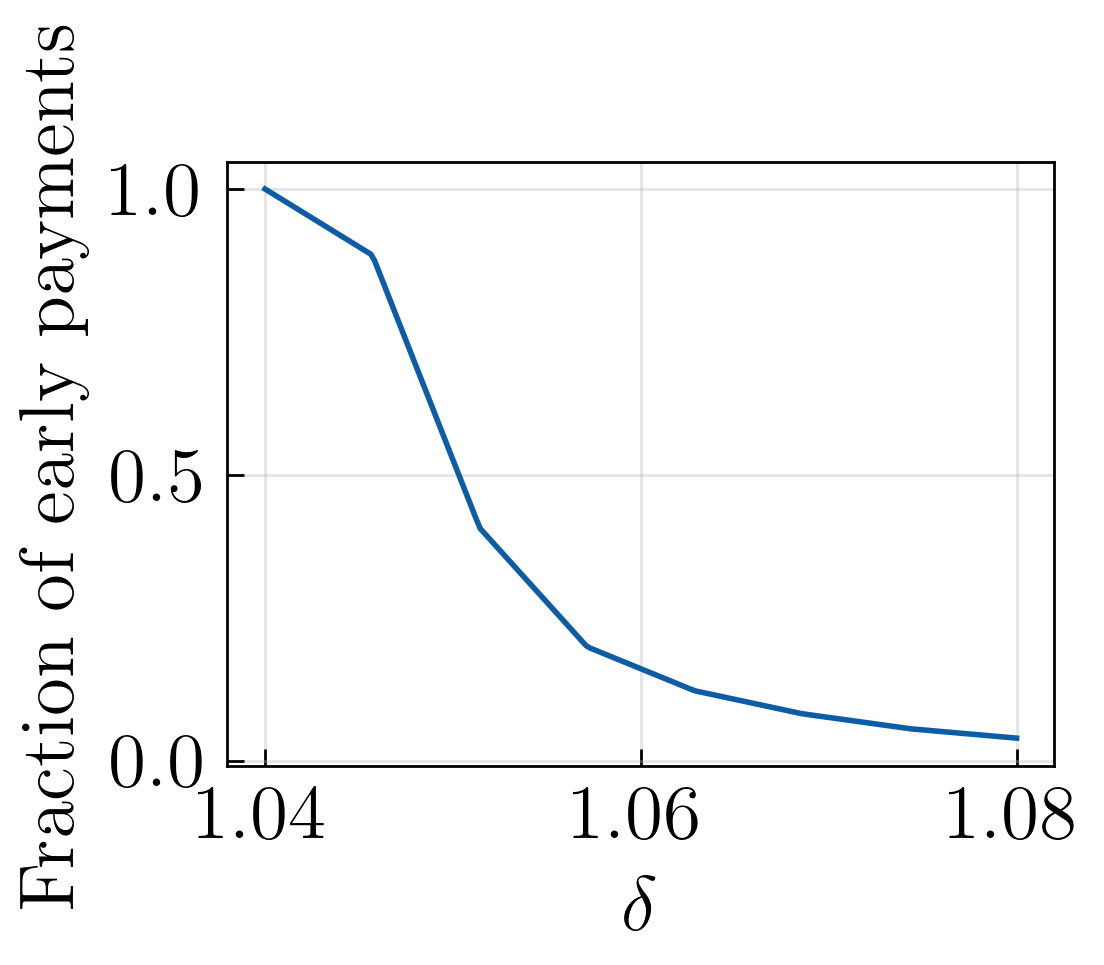

In [15]:
# Parameters
par = par_class()
if fast:
    par.Nm = 50
    par.Nh = 10
    num_points = 8

# Run models
delta_min = 1.04
delta_max = 1.08

zs = []
deltas = np.linspace(delta_min, delta_max, num_points)
for delta in deltas:
    par.delta = delta
    _, sim = run_model(par)
    zs.append(sim.z.mean())

# Interpolate
interpolator = interp1d(deltas, zs, kind='linear')
deltas_interp = np.linspace(delta_min, delta_max, num=200, endpoint=True)
zs_interp = interpolator(deltas_interp)

# Graph
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8/3,2),dpi=dpi)
plt.plot(deltas_interp,zs_interp)
plt.grid(alpha=1/3)
plt.minorticks_off()
ax = plt.gca()
ax.tick_params(top=False, right=False)
plt.xlabel(r'$\delta$')
plt.ylabel('Fraction of early payments')
if save: plt.savefig(r'figs\fig_var_delta.png')

### Varying $\pi$

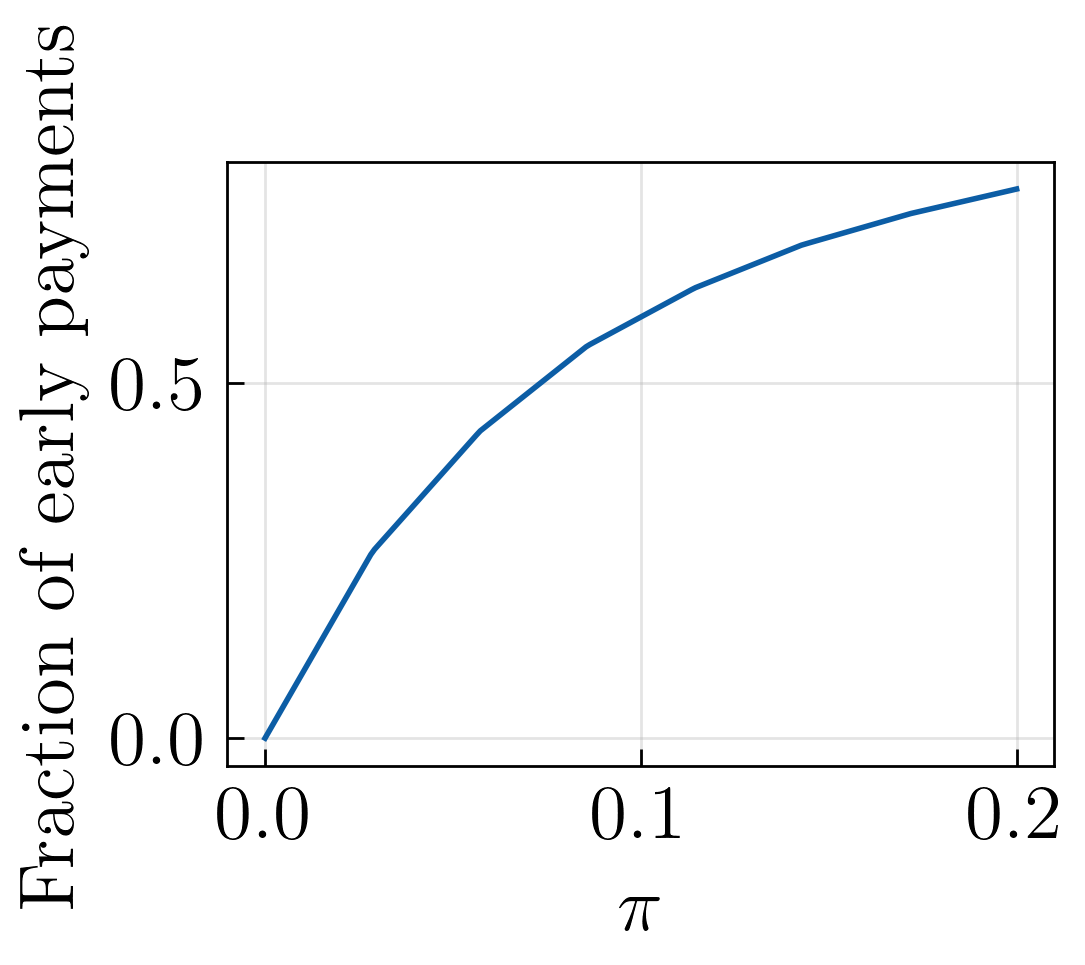

In [16]:
# Parameters
par = par_class()
if fast:
    par.Nm = 50
    par.Nh = 10
    num_points = 8

# Run models
pi_min = 0.00
pi_max = 0.20

zs = []
pis = np.linspace(pi_min, pi_max, num_points)
for pi in pis:
    par.pi = pi
    _, sim = run_model(par)
    zs.append(sim.z.mean())

# Interpolate
interpolator = interp1d(pis, zs, kind='linear')
pis_interp = np.linspace(pi_min, pi_max, num=200, endpoint=True)
zs_interp = interpolator(pis_interp)

# Graph
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8/3,2),dpi=dpi)
plt.plot(pis_interp,zs_interp)
plt.grid(alpha=1/3)
plt.minorticks_off()
ax = plt.gca()
ax.tick_params(top=False, right=False)
plt.xlabel(r'$\pi$')
plt.ylabel('Fraction of early payments')
if save: plt.savefig(r'figs\fig_var_pi.png')

### Varying $\mu$

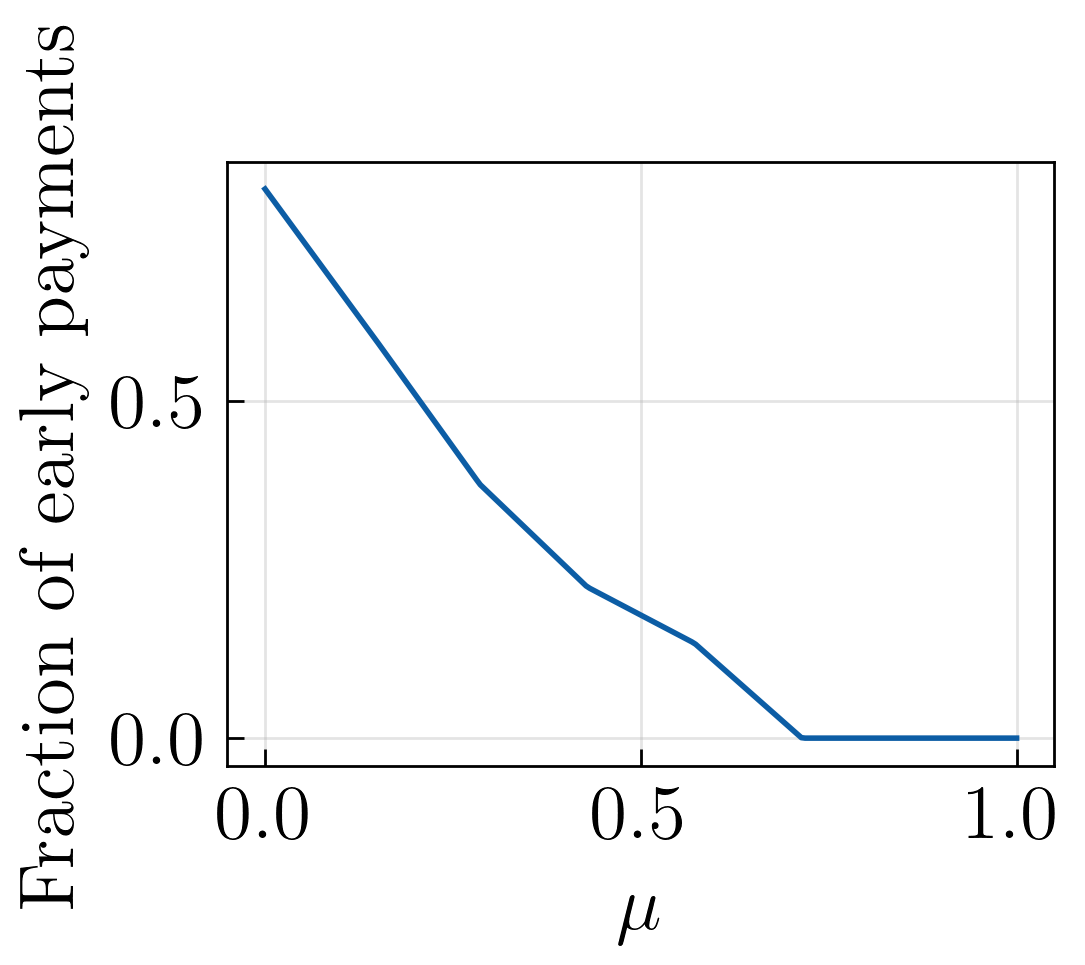

In [17]:
# Parameters
par = par_class()
if fast:
    par.Nm = 50
    par.Nh = 10
    num_points = 8

# Run models
mu_min = 0.0
mu_max = 1.0

zs = []
mus = np.linspace(mu_min, mu_max, num_points)
for mu in mus:
    par.mu = mu
    _, sim = run_model(par)
    zs.append(sim.z.mean())

# Interpolate
interpolator = interp1d(mus, zs, kind='linear')
mus_interp = np.linspace(mu_min, mu_max, num=200, endpoint=True)
zs_interp = interpolator(mus_interp)

# Graph
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8/3,2),dpi=dpi)
plt.plot(mus_interp,zs_interp)
plt.grid(alpha=1/3)
plt.minorticks_off()
ax = plt.gca()
ax.tick_params(top=False, right=False)
plt.xlabel(r'$\mu$')
plt.ylabel('Fraction of early payments')
if save: plt.savefig(r'figs\fig_var_mu.png')

### Varying $\sigma_{\xi}$

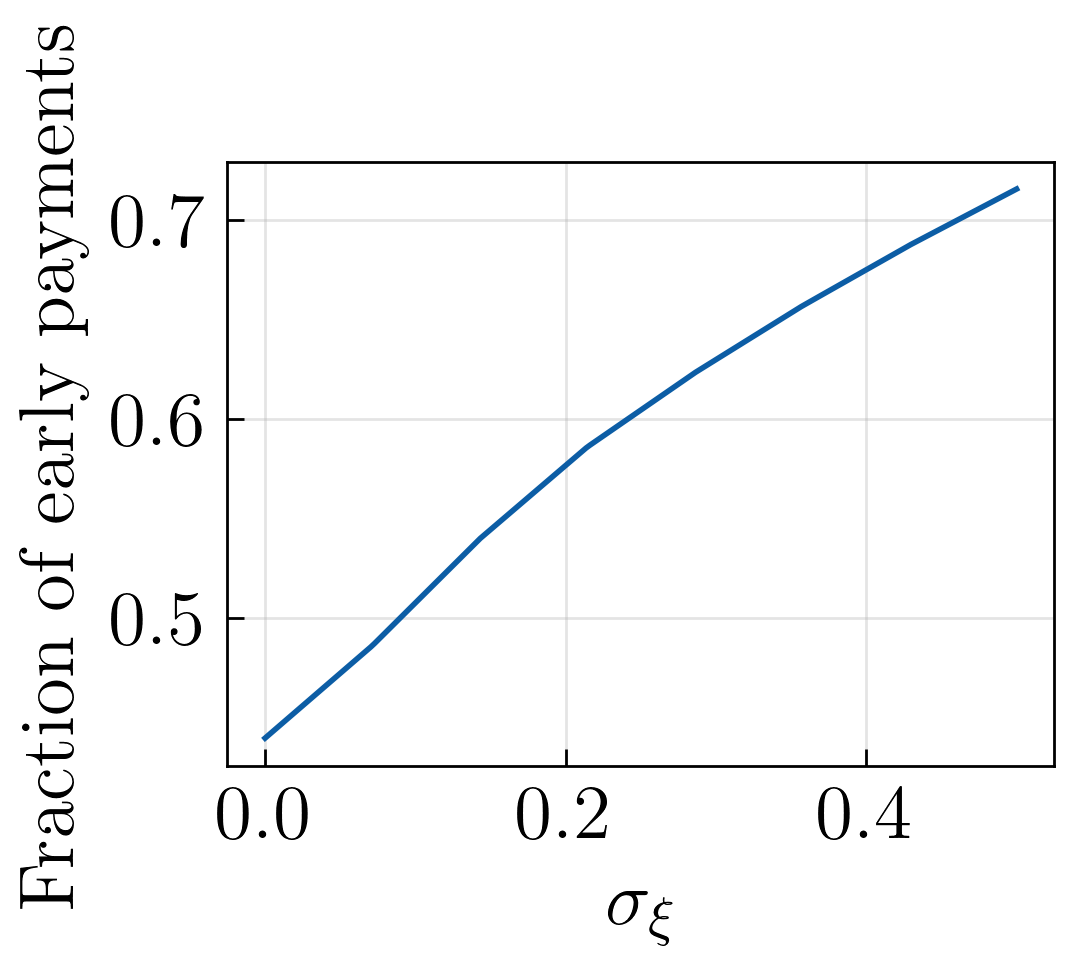

In [18]:
# Parameters
par = par_class()
if fast:
    par.Nm = 50
    par.Nh = 10
    num_points = 8

# Run models
sigma_xi_min = 0.0
sigma_xi_max = 0.5

zs = []
sigma_xis = np.linspace(sigma_xi_min, sigma_xi_max, num_points)
for sigma_xi in sigma_xis:
    par.sigma_xi = sigma_xi
    _, sim = run_model(par)
    zs.append(sim.z.mean())

# Interpolate
interpolator = interp1d(sigma_xis, zs, kind='linear')
sigma_xis_interp = np.linspace(sigma_xi_min, sigma_xi_max, num=200, endpoint=True)
zs_interp = interpolator(sigma_xis_interp)

# Graph
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8/3,2),dpi=dpi)
plt.plot(sigma_xis_interp,zs_interp)
plt.grid(alpha=1/3)
plt.minorticks_off()
ax = plt.gca()
ax.tick_params(top=False, right=False)
plt.xlabel(r'$\sigma_{\xi}$')
plt.ylabel('Fraction of early payments')
if save: plt.savefig(r'figs\fig_var_sigma_xi.png')

### Varying $\sigma_{\psi}$

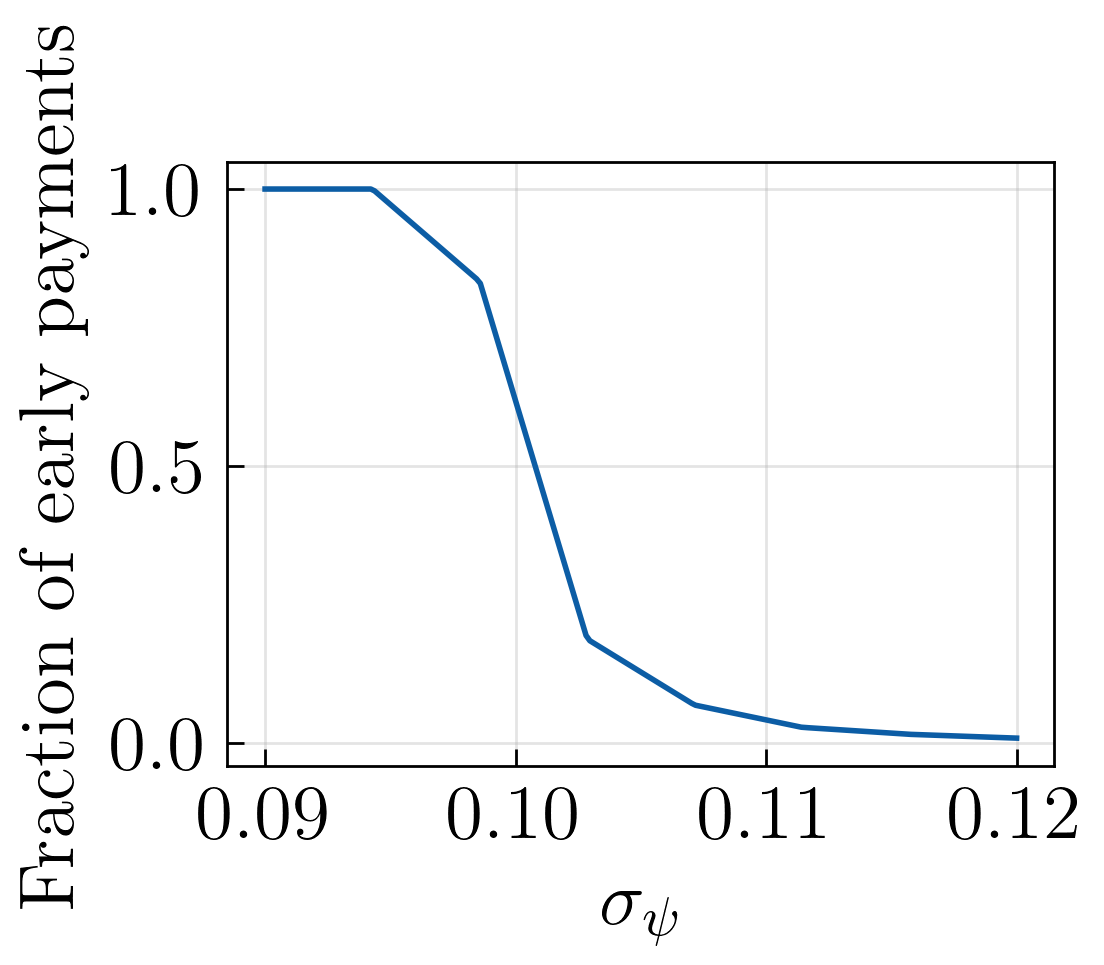

In [19]:
# Parameters
par = par_class()
if fast:
    par.Nm = 50
    par.Nh = 10
    num_points = 8

# Run models
sigma_psi_min = 0.09
sigma_psi_max = 0.12

zs = []
sigma_psis = np.linspace(sigma_psi_min, sigma_psi_max, num_points)
for sigma_psi in sigma_psis:
    par.sigma_psi = sigma_psi
    _, sim = run_model(par)
    zs.append(sim.z.mean())

# Interpolate
interpolator = interp1d(sigma_psis, zs, kind='linear')
sigma_psis_interp = np.linspace(sigma_psi_min, sigma_psi_max, num=200, endpoint=True)
zs_interp = interpolator(sigma_psis_interp)

# Graph
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8/3,2),dpi=dpi)
plt.plot(sigma_psis_interp,zs_interp)
plt.grid(alpha=1/3)
plt.minorticks_off()
ax = plt.gca()
ax.tick_params(top=False, right=False)
ax.xaxis.set_ticks(np.arange(sigma_psi_min, sigma_psi_max+0.005, 0.01))
plt.xlabel(r'$\sigma_{\psi}$')
plt.ylabel('Fraction of early payments')
if save: plt.savefig(r'figs\fig_var_sigma_psi.png')

### Varying $\sigma_d$

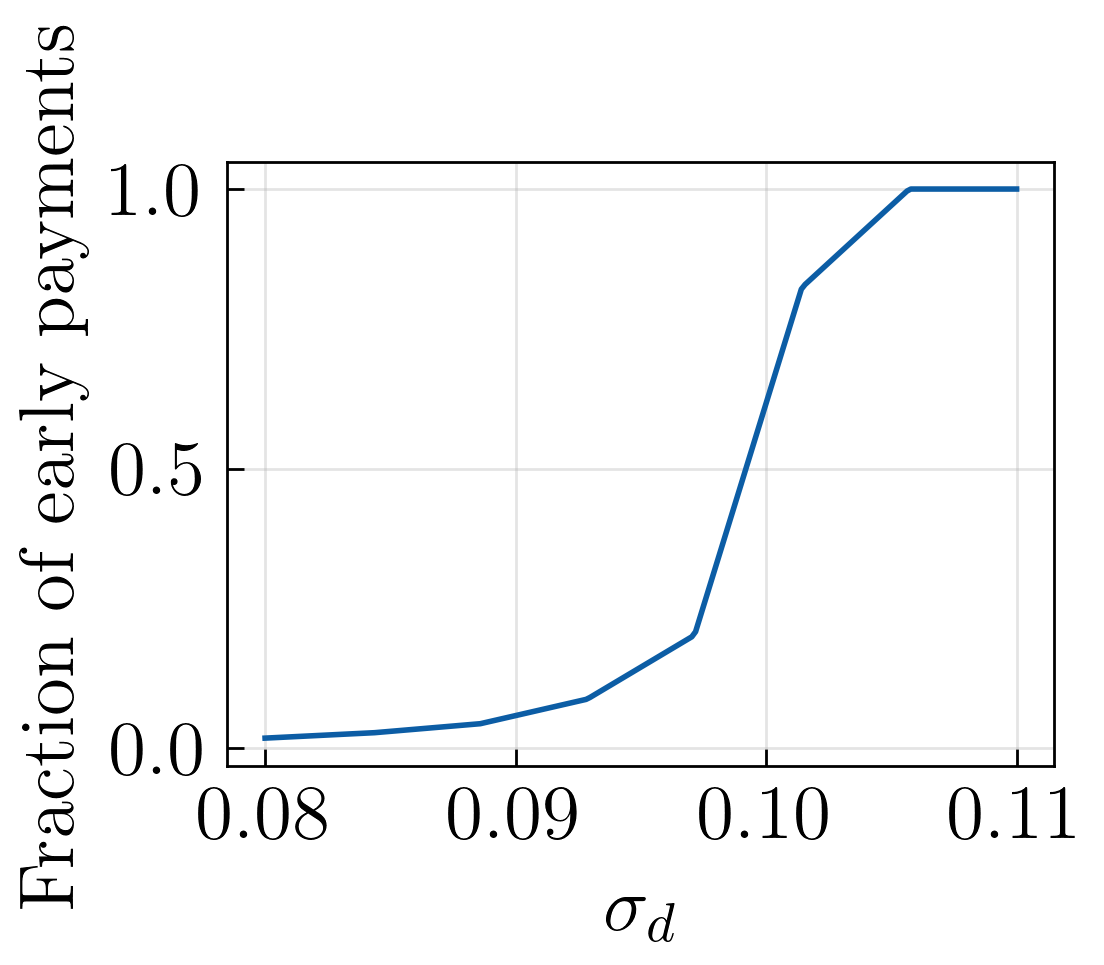

In [20]:
# Parameters
par = par_class()
if fast:
    par.Nm = 50
    par.Nh = 10
    num_points = 8

# Run models
sigma_d_min = 0.08
sigma_d_max = 0.11

zs = []
sigma_ds = np.linspace(sigma_d_min, sigma_d_max, num_points)
for sigma_d in sigma_ds:
    par.sigma_d = sigma_d
    _, sim = run_model(par)
    zs.append(sim.z.mean())

# Interpolate
interpolator = interp1d(sigma_ds, zs, kind='linear')
sigma_ds_interp = np.linspace(sigma_d_min, sigma_d_max, num=200, endpoint=True)
zs_interp = interpolator(sigma_ds_interp)

# Graph
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8/3,2),dpi=dpi)
plt.plot(sigma_ds_interp,zs_interp)
plt.grid(alpha=1/3)
plt.minorticks_off()
ax = plt.gca()
ax.tick_params(top=False, right=False)
ax.xaxis.set_ticks(np.arange(sigma_d_min, sigma_d_max+0.01, 0.01))
plt.xlabel(r'$\sigma_d$')
plt.ylabel('Fraction of early payments')
if save: plt.savefig(r'figs\fig_var_sigma_d.png')

# Unused figures:

### Bonus: Payouts as a function of $\delta$ and $R$

In [ ]:
# Parameters
par = par_class()
par.pi = 0.0
par.sigma_d = 0.0
par.sigma_xi = 0.0
par.sigma_psi = 0.0
par.Nd = 1
par.Npsi = 1
par.Nxi = 1
par.simN = 1
if fast:
    par.Nm = 50
    par.Nh = 10
if True:
    par.Nm = 20
    par.Nh = 5

# Run models
n = 5
z = np.ones((n-1,n-1))
betas_flat = np.linspace(0.96, 0.99, n-1)
betas_flat_centered = (betas_flat + 0.005)
deltas_flat = np.linspace(1.04, 1.07, n-1)
deltas_flat_centered = (deltas_flat + 0.005)
for i,delta in enumerate(deltas_flat):
    for j,beta in enumerate(betas_flat):
        par.delta = delta
        par.beta = beta
        _, sim = run_model(par)
        z_mean = sim.z.mean()
        z[j,i] = z_mean
        
# Create figure
plt.figure(figsize=(4,3),dpi=dpi)
x = deltas_flat_centered
y = betas_flat_centered
extent = [x.min()-0.005, x.max()+0.005, y.min()-0.005, y.max()+0.005]
im = plt.imshow(z, interpolation="nearest", extent=extent, origin="lower")
plt.minorticks_off()
ax = plt.gca()
ax.tick_params(top=False, right=False)
plt.xlabel(r'$\delta$')
plt.ylabel(r'$\beta$')
values = np.unique(z.ravel())
labels = []
for val in values:
    if int(val) == 0:
        labels.append('Late ($z=0$)')
    else:
        labels.append('Early ($z=1$)')
colors = [im.cmap(im.norm(value)) for value in values]
patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(labels))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 0.6), loc=2, borderaxespad=0., frameon=True)
plt.xticks(deltas_flat)
plt.xlim([1.04, 1.08])
plt.ylim([0.96, 1.00])
plt.yticks(betas_flat)
plt.grid(color='black')

#Hide major tick labels
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.yaxis.set_major_formatter(ticker.NullFormatter())

# Customize minor tick labels
ax.xaxis.set_minor_locator(ticker.FixedLocator([1.045, 1.055, 1.065, 1.075]))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(['1.04','1.05','1.06','1.07']))
ax.yaxis.set_minor_locator(ticker.FixedLocator([0.965, 0.975, 0.985, 0.995]))
ax.yaxis.set_minor_formatter(ticker.FixedFormatter(['0.96','0.97','0.98','0.99']))
ax.tick_params(which='minor', length=0)
if save: plt.savefig(r'figs\fig2.png')

### Bonus: Standard Buffer-Stock

In [ ]:
# Parameters
par = par_class()
par.alpha = 0.0
par.sigma_d = 0.0
par.Nh = 2
par.Nd = 1
if fast:
    par.Nm = 50

# Model
_, sim = run_model(par)

# Plot
fig,ax = plt.subplots(2,2,figsize=(8,6),dpi=dpi)
ax[0,0].plot(range(25,80), sim.Y.mean(axis=0))
ax[0,1].plot(range(25,80), sim.M.mean(axis=0))
ax[1,0].plot(range(25,80), sim.C.mean(axis=0))
ax[1,1].plot(range(25,80), sim.A.mean(axis=0))
ax[0,0].set_title('Income, $Y_t$')
ax[0,1].set_title('Cash-on-hand, $M_t$')
ax[1,0].set_title('Consumption, $C_t$')
ax[1,1].set_title('End-of-period assets, $A_t$')
for i in [0,1]:
    for j in [0,1]:
        ax[i,j].grid(alpha=1/3) # Make grid
        ax[i,j].minorticks_off() # Remove minor ticks
        ax[i,j].tick_params(top=False, right=False) # Remove major ticks on top and right 
        if (i,j) == (1,1): ax[i,j].axhline(0,color='black',alpha=1,lw=0.5) # Add zero line
fig.subplots_adjust(hspace=0.23)